## EDA: Exploratory Data Analysis

This notebook is concerned with the study and statistical analysis of the data made available during the test period. Basically, we have three JSON files:

1. **profile.json**: Rewards program users;
2. **portfolio.json**: Offers sent during 30-day test period;
3. **transcript.json**: Event log.

Hence, we are going to look for missing values, bulk statistics and interactions between variables. Moreover, we will generate the final datasets, which will be used for training and further model evaluation.

### 1. Libraries

Importing useful libraries to carry out data analysis and build insightful visualizations.

In [1]:
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
import warnings
warnings.filterwarnings("ignore")

### 2. Reading Files

Here we import the files by taking advantage of a module in `pandas` that reads JSON automatically. The only thing we n eed to pay attention to is the fact that we are supposed to add a parameter `lines` set to `True`, since this is how our files are organized.

In [2]:
df_portfolio = pd.read_json("./raw_data/portfolio.json", lines=True)
df_profile = pd.read_json("./raw_data/profile.json", lines=True)
df_transcript = pd.read_json("./raw_data/transcript.json", lines=True)

#### 2.1. Portfolio

This file provides us with a list of the 10 promotional offers available during the 30-day test period.

In [3]:
df_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
df_portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Fortunately, we notice that there are no missing values.

Studying the data more closely, it is possible to notice that there are three different types of offer:

* __bogo (buy one, get one)__: the difficulty is intermediary, however the reward reflects the amount spent;
* __discount__: the diffculty is higher, and the reward is lower;
* __informational__: no reward and difficulty at all, it is just a reminder.

In [5]:
(
    df_portfolio.loc[:, ["offer_type", "reward", "difficulty", "duration"]]
                .groupby("offer_type")
                .mean()
)

,reward,difficulty,duration
offer_type,,,
bogo,7.5,7.50,6.0
discount,3.0,11.75,8.5
informational,0.0,0.00,3.5


It is important to notice that offers are available only within a time window. Therefore, it is necessary to look at `duration` (in days) to decide whether or not the user made the transaction during this period.

#### 2.2. Profile

This file provides us with a list of registered customers who took part in the test period.

In [6]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
df_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Sanity check: are all users unique?

In [8]:
df_profile.id.nunique()

17000

Here we realize that there are missing values both in `gender` and `income` columns. However, we should pay attention to the fact that `age` has some entries equal to 118, which in this case is the default value for missing field.

In [9]:
df_profile.loc[:, "age"] = df_profile.loc[:, "age"].apply(lambda x: np.nan if x==118 else x)

In [10]:
df_profile.isnull().sum()

gender              2175
age                 2175
id                     0
became_member_on       0
income              2175
dtype: int64

It is a good idea to convert `became_member_on` to a datetime field.

In [11]:
df_profile.loc[:, "became_member_on"] = pd.to_datetime(
                                                df_profile.loc[:, "became_member_on"]
                                                          .astype(str)
                                                          .apply(lambda x: f"{x[-2:]}-{x[4:-2]}-{x[:4]}")
                                        )

In [12]:
df_profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


#### 2.3. Transcript

This file provides us with the records of user activity during the test period.

In [13]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [14]:
df_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Fortunately, there are no missing values again.

There are fours types of events:

* __offer received__: when a given offer is sent to a customer;
* __offer viewed__: when the customer actually visualized the offer;
* __transaction__: any buy user made;
* __offer completed__: offer requirements were properly satisfied.

In [15]:
df_transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

The variable `time` allows us to understand the order with which events took place. However, it is expressed in hours, so it is useful to calculate it in days, so it is comparable against the duration of the promotional offers.

In [16]:
df_transcript.loc[:, "time_in_days"] = df_transcript.loc[:, "time"] / 24

In [17]:
df_transcript.describe()

,time,time_in_days
count,306534.000000,306534.000000
mean,366.382940,15.265956
std,200.326314,8.346930
min,0.000000,0.000000
25%,186.000000,7.750000
50%,408.000000,17.000000
75%,528.000000,22.000000
max,714.000000,29.750000


We should take into account that sometimes users will receive offers, however they won't see it. Even though, they are going to make organic purchases and the offer may be completed. This is **NOT** considered as a customer who responded to an offer, since he/she did not even know about it.

### 3. Building Final Dataset and Engineering Features

Since we aim to predict users who will very likely respond to specific offers. We need to design a new dataset that flags users, offers received and whether or not they responded to it - our target variable to build the classification model later on.

#### 3.1 Obtaining labels

For each pair person-offer in a given point of time, we are going to flag it as either 1 (user responded to the promotional offer) or 0 (user did not respond to the promotional offer). This will be our base dataset to which features will be added later on.

##### All Offers received by customer

In [18]:
offers_received = df_transcript.loc[df_transcript.event == "offer received", :]
offers_received.loc[:, "offer"] = offers_received.loc[:, "value"].apply(lambda x: x["offer id"])
offers_received = offers_received.loc[:, ["person", "offer", "time_in_days"]]

offers_received = pd.merge(offers_received, df_portfolio.loc[:, ["id", "duration", "difficulty"]],
                           left_on="offer", right_on="id", how="inner")

offers_received.head()

,person,offer,time_in_days,id,duration,difficulty
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5
1,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5
2,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5
3,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5
4,57dd18ec5ddc46828afb81ec5977bef2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5


##### Offers viewed on time

In [19]:
offers_viewed = df_transcript.loc[df_transcript.event == "offer viewed", :]
offers_viewed.loc[:, "offer"] = offers_viewed.loc[:, "value"].apply(lambda x: x["offer id"])

offers_viewed = pd.merge(offers_received, offers_viewed, on=["person", "offer"], 
                         how="outer", suffixes=["_received", "_viewed"])

offers_viewed = offers_viewed.loc[
    (offers_viewed.time_in_days_viewed > offers_viewed.time_in_days_received) &
    (offers_viewed.time_in_days_viewed - offers_viewed.time_in_days_received <= offers_viewed.duration), :]

cols = ["person", "offer", "duration", "difficulty", "time_in_days_received", "time_in_days_viewed"]
offers_viewed = offers_viewed.loc[:, cols]

offers_viewed.head()

,person,offer,duration,difficulty,time_in_days_received,time_in_days_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,0.0,0.25
2,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,24.0,29.75
3,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,0.0,2.00
6,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,0.0,1.25
8,a3b9b4bf115e4564933ea2e4bc936843,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,5,0.0,0.75


##### Transactions for difficulty 0 (there is no offer completed in these scenarios)

In [20]:
transactioned = df_transcript.loc[df_transcript.event == "transaction", ["person", "time_in_days"]]

transactioned = pd.merge(offers_viewed, transactioned, on=["person"], 
                         how="outer", suffixes=["_viewed", "_transactioned"])

transactioned = (transactioned.loc[
    (transactioned.time_in_days > transactioned.time_in_days_viewed) &
    (transactioned.time_in_days - transactioned.time_in_days_received <= transactioned.time_in_days_received) &
    (transactioned.difficulty == 0), ["person", "offer", "time_in_days_received", "time_in_days"]]
                              .groupby(["person", "offer", "time_in_days_received"])
                              .first()
                              .reset_index()
                              .iloc[:, :-1]
)
transactioned.head()

,person,offer,time_in_days_received
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0
2,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,14.0
3,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,14.0
4,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,21.0


##### Offers completed for all cases except promotional offers

In [21]:
offers_completed = df_transcript.loc[df_transcript.event == "offer completed", :]
offers_completed.loc[:, "offer"] = offers_completed.loc[:, "value"].apply(lambda x: x["offer_id"])

offers_completed = pd.merge(offers_viewed, offers_completed, on=["person", "offer"], 
                            how="outer", suffixes=["_viewed", "_completed"])

offers_completed = offers_completed.loc[
    (offers_completed.time_in_days > offers_completed.time_in_days_viewed) &
    (offers_completed.time_in_days - offers_completed.time_in_days_received <= offers_completed.duration) &
    (offers_completed.difficulty != 0), :]

cols = ["person", "offer", "duration", "difficulty", "time_in_days_received", 
        "time_in_days_viewed", "time_in_days"]
offers_completed = offers_completed.loc[:, cols]

offers_completed.head()

,person,offer,duration,difficulty,time_in_days_received,time_in_days_viewed,time_in_days
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,0.0,0.25,5.50
3,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,0.0,1.25,2.75
5,32fbf97e89274e8a935903f2ad095e1f,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,0.0,4.00,6.50
8,32fbf97e89274e8a935903f2ad095e1f,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,14.0,15.00,15.25
10,4e4c47b460b1414c8ddd459b61f84b9e,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,5.0,0.0,0.50,1.00


###### Concatenating Results

In [22]:
offers_successful = pd.concat(
    [
        offers_completed.loc[:, ["person", "offer", "time_in_days_received"]],
        transactioned.loc[:, ["person", "offer", "time_in_days_received"]]
    ],
    axis=0
)
offers_successful = offers_successful.drop_duplicates()
offers_successful.loc[:, "responded_customer"] = 1
offers_successful.head()

,person,offer,time_in_days_received,responded_customer
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1
3,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1
5,32fbf97e89274e8a935903f2ad095e1f,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1
8,32fbf97e89274e8a935903f2ad095e1f,9b98b8c7a33c4b65b9aebfe6a799e6d9,14.0,1
10,4e4c47b460b1414c8ddd459b61f84b9e,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1


##### Final Base Dataset

In [23]:
offers_received = offers_received.rename(columns={"time_in_days": "time_in_days_received"})

df = pd.merge(
    offers_received.loc[:, ["person", "offer", "time_in_days_received"]],
    offers_successful,
    how="left",
    on=["person", "offer", "time_in_days_received"]
)
df = (df.sort_values(by=["person", "offer", "time_in_days_received"])
        .fillna(0)
     )
df.loc[:, "responded_customer"] = df.loc[:, "responded_customer"].astype(int)
df.head()

,person,offer,time_in_days_received,responded_customer
22015,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0
56225,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,1
70180,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,1
42206,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,0
28317,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,0


Since we have a final base dataset with associated labels for each pair person-offer in a given point in time, it is possible for us to calculate the **baseline conversion rate**.

In [24]:
print(f"Baseline conversion rate: {100*df.responded_customer.mean():.2f}%")

Baseline conversion rate: 27.65%


Additionally, we can also obtain the conversion rate for each offer:

In [25]:
cr_per_offer = (
    df.groupby("offer")[["responded_customer"]]
      .mean()
      .reset_index()
)

print("Baseline conversion rates for each single offer:\n")
for idx, row in cr_per_offer.iterrows():
    print(f"\t{row.offer}: {100*row.responded_customer:.2f}%")

Baseline conversion rates for each single offer:

	0b1e1539f2cc45b7b9fa7c272da2e1d7: 14.87%
	2298d6c36e964ae4a3e7e9706d1fb8c2: 36.80%
	2906b810c7d4411798c6938adc9daaa5: 20.51%
	3f207df678b143eea3cee63160fa8bed: 27.53%
	4d5c57ea9a6940dd891ad53e9dbe8da0: 21.27%
	5a8bc65990b245e5a138643cd4eb9837: 44.36%
	9b98b8c7a33c4b65b9aebfe6a799e6d9: 19.67%
	ae264e3637204a6fb9bb56bc8210ddfd: 23.11%
	f19421c1d4aa40978ebb69ca19b0e20d: 27.12%
	fafdcd668e3743c1bb461111dcafc2a4: 41.44%


#### 3.2. Feature Engineering and Final Dataset

Now it is time for us to enrich our base dataset with features that can help us achieve our final goal of predicting which users will likely respond to offers.

##### Customer Features

First, we need to join this base dataframe with the profile dataframe which contains user features.

In [26]:
df = pd.merge(left=df, right=df_profile, how="inner", left_on="person", right_on="id")
df = df.drop(columns=["id"])
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,1,M,33.0,2017-04-21,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,1,M,33.0,2017-04-21,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,0,M,33.0,2017-04-21,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,0,M,33.0,2017-04-21,72000.0


No, we need to decide on which features are going to be used:

* `age`: numerical feature, no changes needed;
* `gender`: categorical feature, conversion needed;
* `became_member_on`: datetime feature, since we do not have any information on when the 30-day test period took place, we will assume a reference date as the maximum value of this field. So, we can estimate for how long a given customer has been a member, even though it is not precise, it is just a matter of scale;
* `income`: numerical feature, no changes needed.

In [27]:
df.loc[:, "gender"] = df.loc[:, "gender"].astype("category")
df.loc[:, "membership_duration"] = (
    (df.loc[:, "became_member_on"].max() - df.loc[:, "became_member_on"]).dt.days
)

df = df.drop(columns=["became_member_on"])
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,1,M,33.0,72000.0,595
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,1,M,33.0,72000.0,595
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,0,M,33.0,72000.0,595
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,0,M,33.0,72000.0,595


##### Promotional Offer Features

First, we need to join this base dataframe with the portfolio dataframe which contains offer features.

In [28]:
df = pd.merge(left=df, right=df_portfolio, how="inner", left_on="offer", right_on="id")
df = df.drop(columns=["id"])
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,membership_duration,reward,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,"[web, email, mobile]",10,7,discount
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,"[web, email, mobile]",10,7,discount
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,"[web, email, mobile]",10,7,discount
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,"[web, email, mobile]",10,7,discount
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,"[web, email, mobile]",10,7,discount


No, we need to decide on which features are going to be used:

* `reward`: numerical feature, no changes needed;
* `channels`: list of categories, we could expand it to have an one-got encoded feature for each channel;
* `difficulty`: numerical feature, no changes needed;
* `duration`: numerical feature, no changes needed;
* `offer_type`: categorical feature, conversion needed.

In [29]:
df.loc[:, "offer_type"] = df.loc[:, "offer_type"].astype("category")

channels = df.channels.explode().unique()

for channel in channels:
    df.loc[:, channel] = df.loc[:, "channels"].apply(lambda x: channel in x).astype(int)
    
df = df.drop(columns=["channels"])

df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,membership_duration,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,10,7,discount,1,1,1,0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,10,7,discount,1,1,1,0
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,10,7,discount,1,1,1,0


##### Transactional Features

It is useful to know the transactional pattern of each user. For instance, if a giver customer makes purchases very often, it is likely that he/she will respond to an offer, or if a customer has not made any purchase for a while, he/she might activate again with an offer.

Hence, we will engineer the following features in this scenario:

* `frequency`: how many purchases per day the customer usually makes;
* `average_purchase`: average value spent by user.

It is important to emphasize that this features will be always calculated prior to the offer receival, in order to **prevent data leakage**.

In [30]:
transactions = df_transcript.loc[df_transcript.event == "transaction", ["person", "value", "time_in_days"]]
transactions.loc[:, "amount"] = transactions.loc[:, "value"].apply(lambda x: x["amount"])
transactions = transactions.drop(columns=["value"])
transactions.head()

,person,time_in_days,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [31]:
key_columns = ["person", "offer", "time_in_days_received"]

df_keys = df.loc[:, key_columns]
df_keys.head()

,person,offer,time_in_days_received
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0


In [32]:
transactional_feats = pd.merge(df_keys, transactions, on=["person"], how="left")
transactional_feats = (
    transactional_feats.loc[(transactional_feats.time_in_days < transactional_feats.time_in_days_received), :]
)
transactional_feats = (
    transactional_feats.groupby(key_columns)
                       .agg({"amount": "mean", "time_in_days": "count"})
                       .reset_index()
                       .rename(columns={"amount": "average_purchase", "time_in_days": "frequency"})
)

In [33]:
df = pd.merge(df, transactional_feats, how="left", on=key_columns)
df.loc[:, "average_purchase"] = df.loc[:, "average_purchase"].fillna(0)
df.loc[:, "frequency"] = df.loc[:, "frequency"].fillna(0)
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,membership_duration,reward,difficulty,duration,offer_type,web,email,mobile,social,average_purchase,frequency
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,10,7,discount,1,1,1,0,14.600000,4.0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.666923,13.0
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.469286,14.0
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,10,7,discount,1,1,1,0,4.855000,2.0
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,10,7,discount,1,1,1,0,6.803333,3.0


##### Final Dataset

Hence, we have the following dataset available:

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 76276
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   person                 76277 non-null  object  
 1   offer                  76277 non-null  object  
 2   time_in_days_received  76277 non-null  float64 
 3   responded_customer     76277 non-null  int64   
 4   gender                 66501 non-null  category
 5   age                    66501 non-null  float64 
 6   income                 66501 non-null  float64 
 7   membership_duration    76277 non-null  int64   
 8   reward                 76277 non-null  int64   
 9   difficulty             76277 non-null  int64   
 10  duration               76277 non-null  int64   
 11  offer_type             76277 non-null  category
 12  web                    76277 non-null  int64   
 13  email                  76277 non-null  int64   
 14  mobile                 76277 non-null 

##### 3.3. Train-Test Split

The last step before we dive deep into statistical analyses of the features and the model development itself is splitting data into training and test sets.

We should be careful to prevent data leakage, since the same offer could be offered to a customer more than once. So, the same data point (or at least very similar) could appear in both sets, leading to an overestimate of final performance.

Therefore, we will take into account the pair offer-person when splitting. In order to do that, we will combine the two id columns and then perform hashing. By bucketizing the hashing result, we will be able to split the datasets accordingly.

In [35]:
N_BUCKETS = 10

df.loc[:, "hash_id"] = df.apply(lambda x: hash(x["person"]+x["offer"]) % N_BUCKETS, axis=1)
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,membership_duration,reward,difficulty,duration,offer_type,web,email,mobile,social,average_purchase,frequency,hash_id
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,10,7,discount,1,1,1,0,14.600000,4.0,7
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.666923,13.0,4
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.469286,14.0,4
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,10,7,discount,1,1,1,0,4.855000,2.0,9
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,10,7,discount,1,1,1,0,6.803333,3.0,8


In [36]:
sorted(df.hash_id.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [37]:
TEST_SIZE = 0.3
idx = int(TEST_SIZE * N_BUCKETS)

df_train = df.loc[df.hash_id >= idx, :]
df_test = df.loc[df.hash_id < idx, :]

Sanity check:

In [38]:
train_size = np.round(df_train.shape[0] / df.shape[0], 2)
test_size = np.round(df_test.shape[0] / df.shape[0], 2)

print(f"Train Size: {train_size}")
print(f"Test Size: {test_size}")

Train Size: 0.7
Test Size: 0.3


In [39]:
df_train.to_csv("./data/train", index=False)
df_test.to_csv("./data/validation", index=False)

### 4. Statistical Analysis

Since the test set is a final step to evaluate performance, we cannot use it to analyze the data, since it could lead to data leakage, and hence it would not reflect real world scenarios.

In the final dataset, we have both numerical and categorical features. Therefore, it makes sense to divide the analysis according to data type.

In [40]:
NUM_FEATURES = [
    "age", "membership_duration", "reward", "difficulty",
    "duration", "average_purchase", "frequency"
]

CAT_FEATURES = [
    "gender", "offer_type", "web", "email", "mobile", "social"
]

TARGET = "responded_customer"

##### Checking for missing values

In [41]:
df_train.isnull().sum()

person                      0
offer                       0
time_in_days_received       0
responded_customer          0
gender                   6875
age                      6875
income                   6875
membership_duration         0
reward                      0
difficulty                  0
duration                    0
offer_type                  0
web                         0
email                       0
mobile                      0
social                      0
average_purchase            0
frequency                   0
hash_id                     0
dtype: int64

#### 4.1. Target

We start the analysis by studying our target variable.

##### Univariate Analysis

In [42]:
df_train.responded_customer.value_counts() / len(df_train)

0    0.724075
1    0.275925
Name: responded_customer, dtype: float64

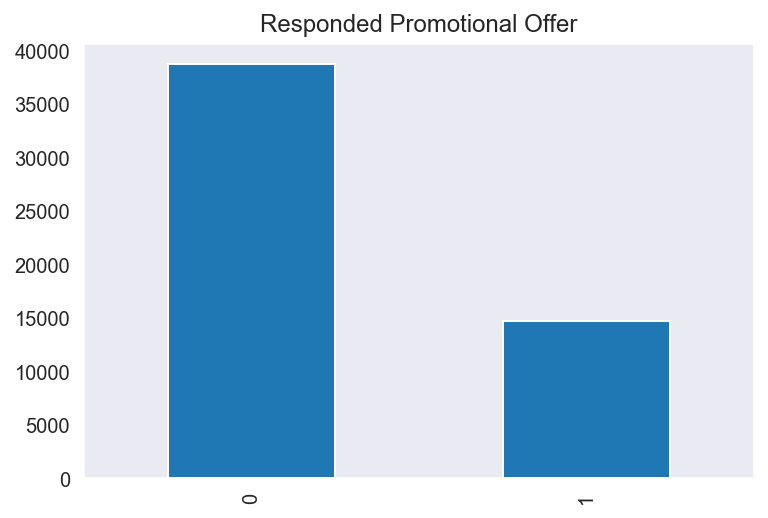

In [43]:
plt.title("Responded Promotional Offer")
df_train.responded_customer.value_counts().plot(kind="bar")
plt.show()

From the visualization above, it is possible to notice that we are dealing with an **imbalanced dataset**, since approximately 28% of the dataset responded to the promotional offer.

Thus, we will have to address this problem during model development. Strategies are:

* __oversampling__: SMOTE technique to create synthetic example of the positive class;
* __weighting__: add different weights according to class in loss function.

Using both simultaneously can lead to better results than relying solely on a single of them.

#### 4.2. Numerical Features

Let's proceed to the numerical features.

##### Univariate Analysis

Most of the variables are well distributed and do not show a lot of outliers. The exceptions are `average_purchase` and `frequency`, since we notice that 95th-percentile and maximum values are very different from each other.

In [44]:
df_train.loc[:, NUM_FEATURES].describe(percentiles=[np.round(p, 2) for p in np.linspace(0.05, 0.95, 10)])

,age,membership_duration,reward,difficulty,duration,average_purchase,frequency
count,46578.000000,53453.000000,53453.000000,53453.000000,53453.000000,53453.000000,53453.000000
mean,54.321353,653.418199,4.186500,7.676594,6.492339,9.714928,3.457804
std,17.409255,422.439390,3.400965,5.532500,2.200920,16.882672,3.664971
min,18.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
5%,24.000000,142.000000,0.000000,0.000000,3.000000,0.000000,0.000000
15%,34.000000,248.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,42.000000,343.000000,2.000000,5.000000,5.000000,0.000000,0.000000
35%,49.000000,412.000000,2.000000,5.000000,5.000000,1.970000,1.000000
45%,53.000000,482.000000,3.000000,7.000000,7.000000,3.130000,2.000000
50%,55.000000,538.000000,3.000000,7.000000,7.000000,3.820000,3.000000


In [45]:
def boxplot(data: pd.DataFrame, num_cols: List[str], by: str = None, hue: str = None):
    """
    Function to plot boxplots for either univariate or bivariate statistical analysis.
    
    Args: 
        data (pandas dataframe): dataframe containing the actual data
        num_cols (list of str): numerical columns whose boxplots will be displayed
        by (str): optional categorical column to group the data
        hue (str): optional categorical column to discriminate the data further
    
    Returns: 
        None
    """
    plt.figure(figsize=(12, 2*len(num_cols)))
    for i, num_col in enumerate(num_cols):
        ax = plt.subplot(len(num_cols), 1, i+1)
        if by is not None:
            sns.boxplot(y=num_col, x=by, hue=hue, data=data, ax=ax)
        else:
            sns.boxplot(x=num_col, data=data, ax=ax)
    plt.tight_layout()
    plt.show()
    
    
def histogram(data: pd.DataFrame, num_cols: List[str]):
    """
    Function to plot histograms for statistical analysis.
    
    Args: 
        data (pandas dataframe): dataframe containing the actual data
        num_cols (list of str): numerical columns whose histograms will be displayed
    
    Returns: 
        None
    """
    plt.figure(figsize=(12, 4*len(num_cols)))
    for i, num_col in enumerate(num_cols):
        ax = plt.subplot(len(num_cols), 1, i+1)
        data.loc[:, num_col].hist(ax=ax)
        ax.set_xlabel(num_col)
    plt.tight_layout()
    plt.show()

We can conclude that `age` is the variable whose distribution is closer to a normal distribution, even though it is almost bimodal.

The features related to the offers available are limited to certain values, which results in very few representative values.

`membership_duration` and `frequency` show a skewed distribution, whereas `average_purchase` concetrates almost all values close to zero - in this case, outliers might be a problem. Perhaps some sort of **winsorizing** is useful here.

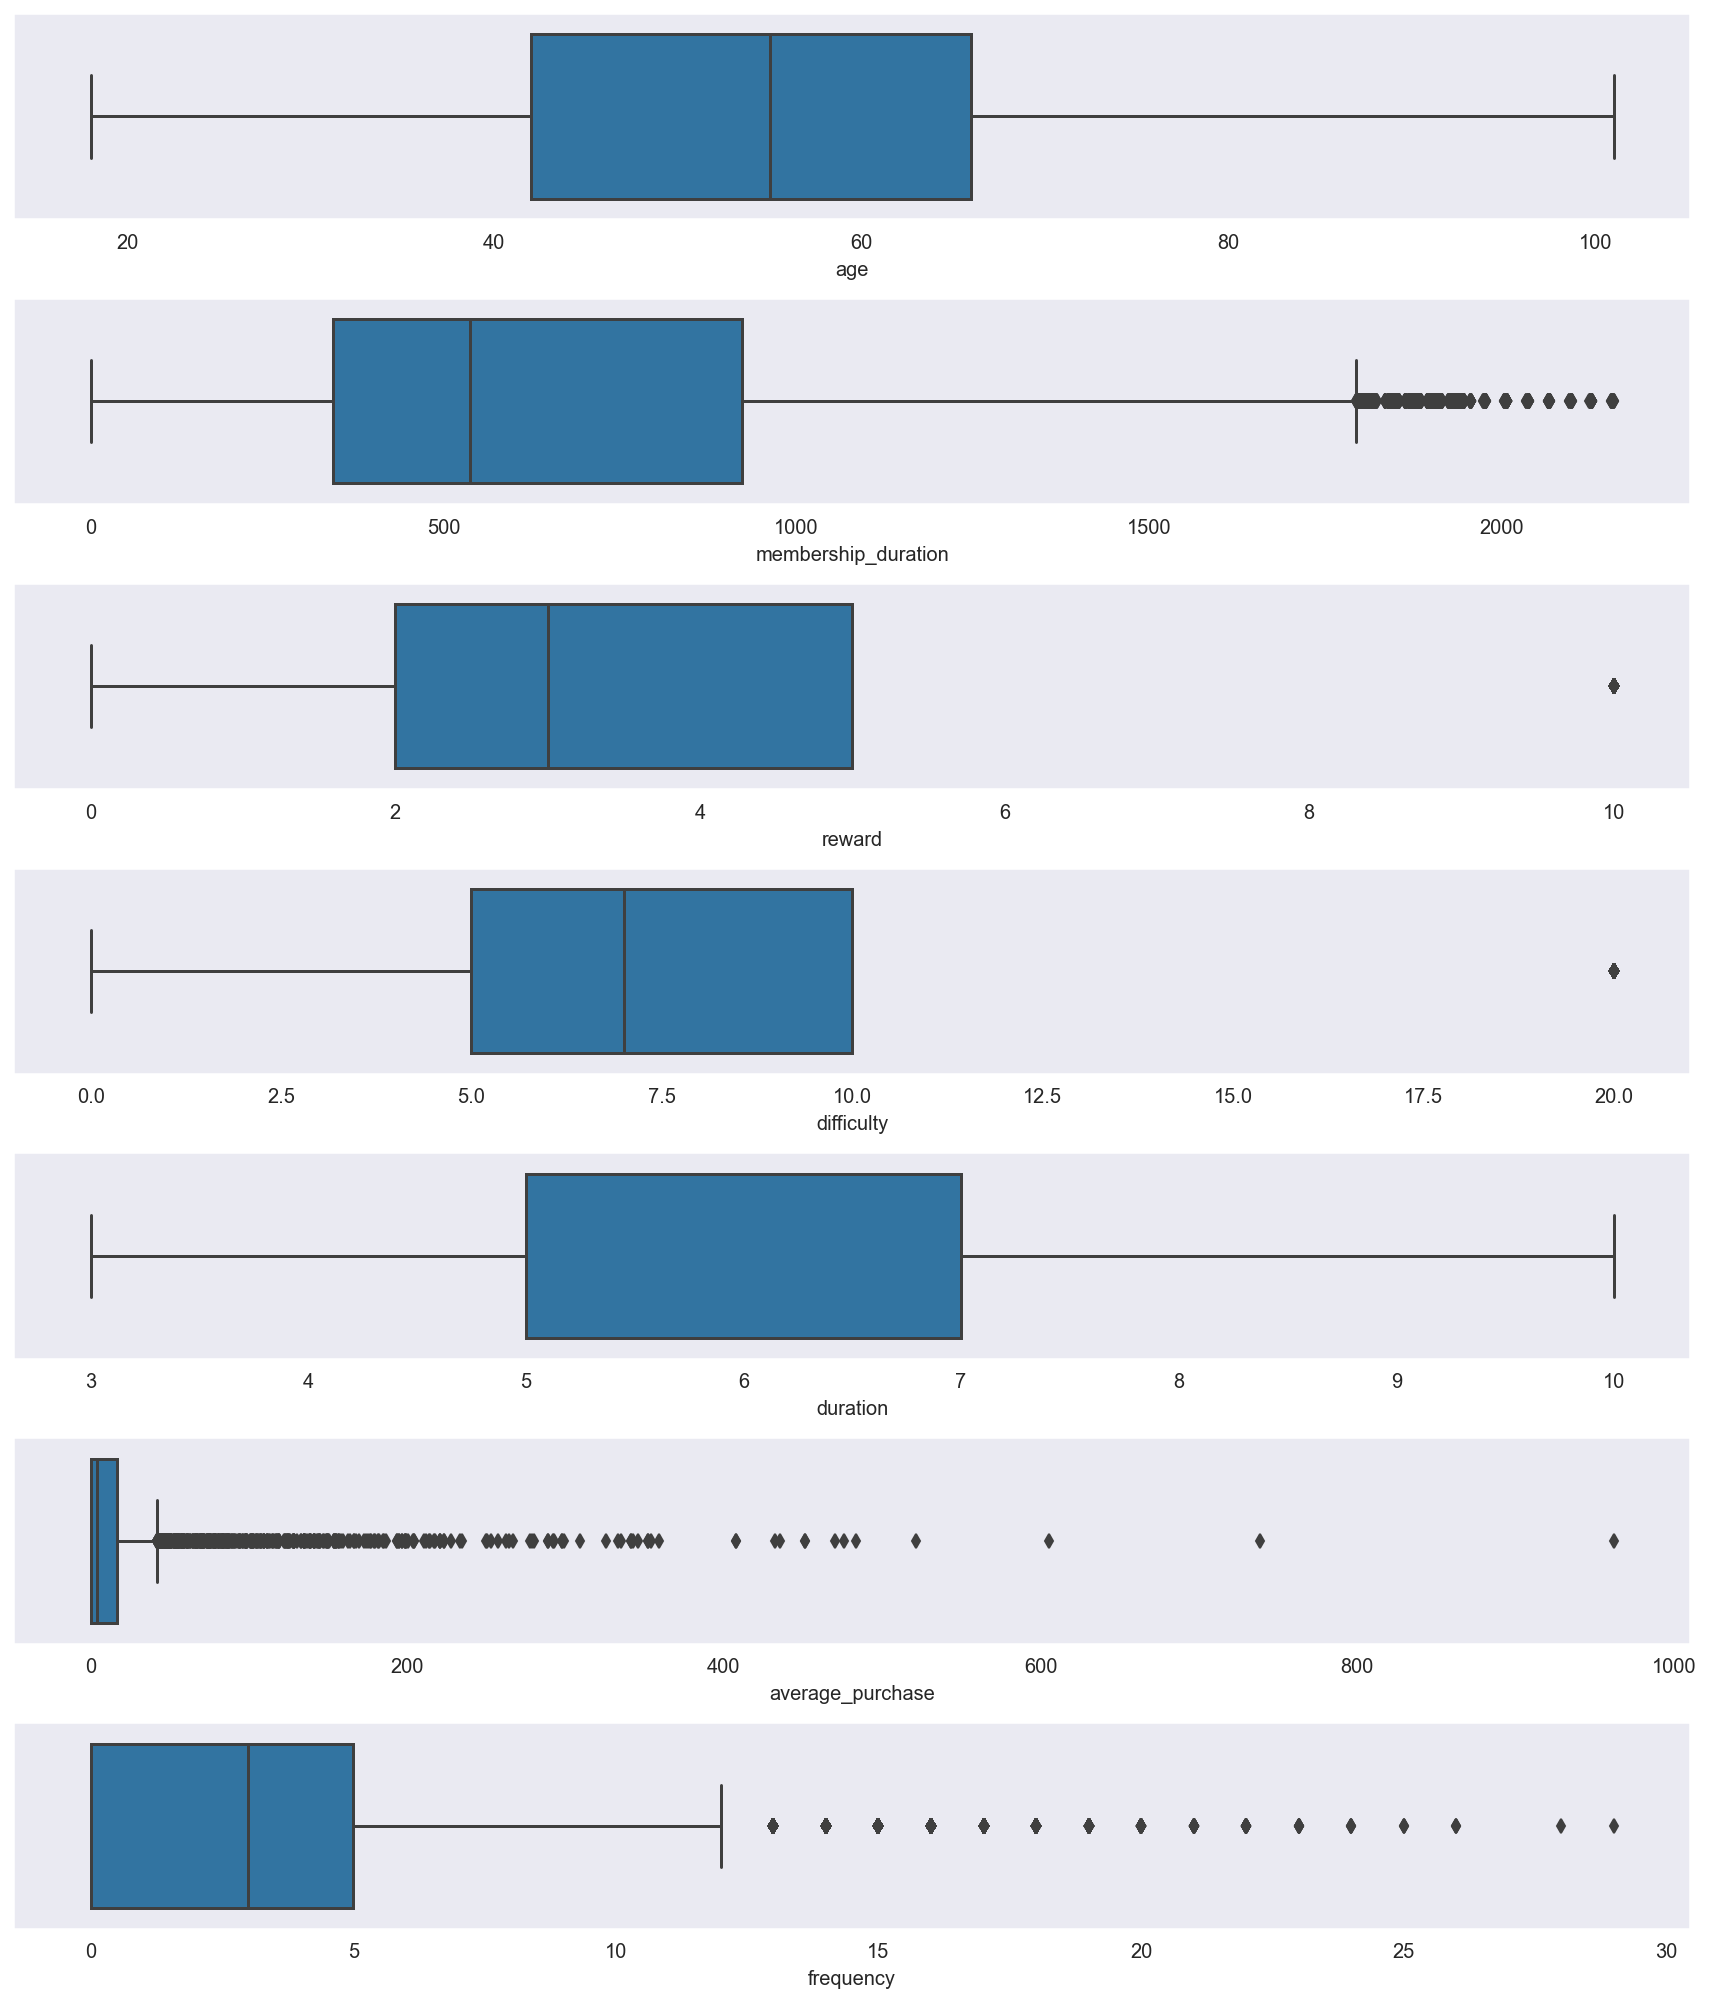

In [46]:
boxplot(df_train, NUM_FEATURES)

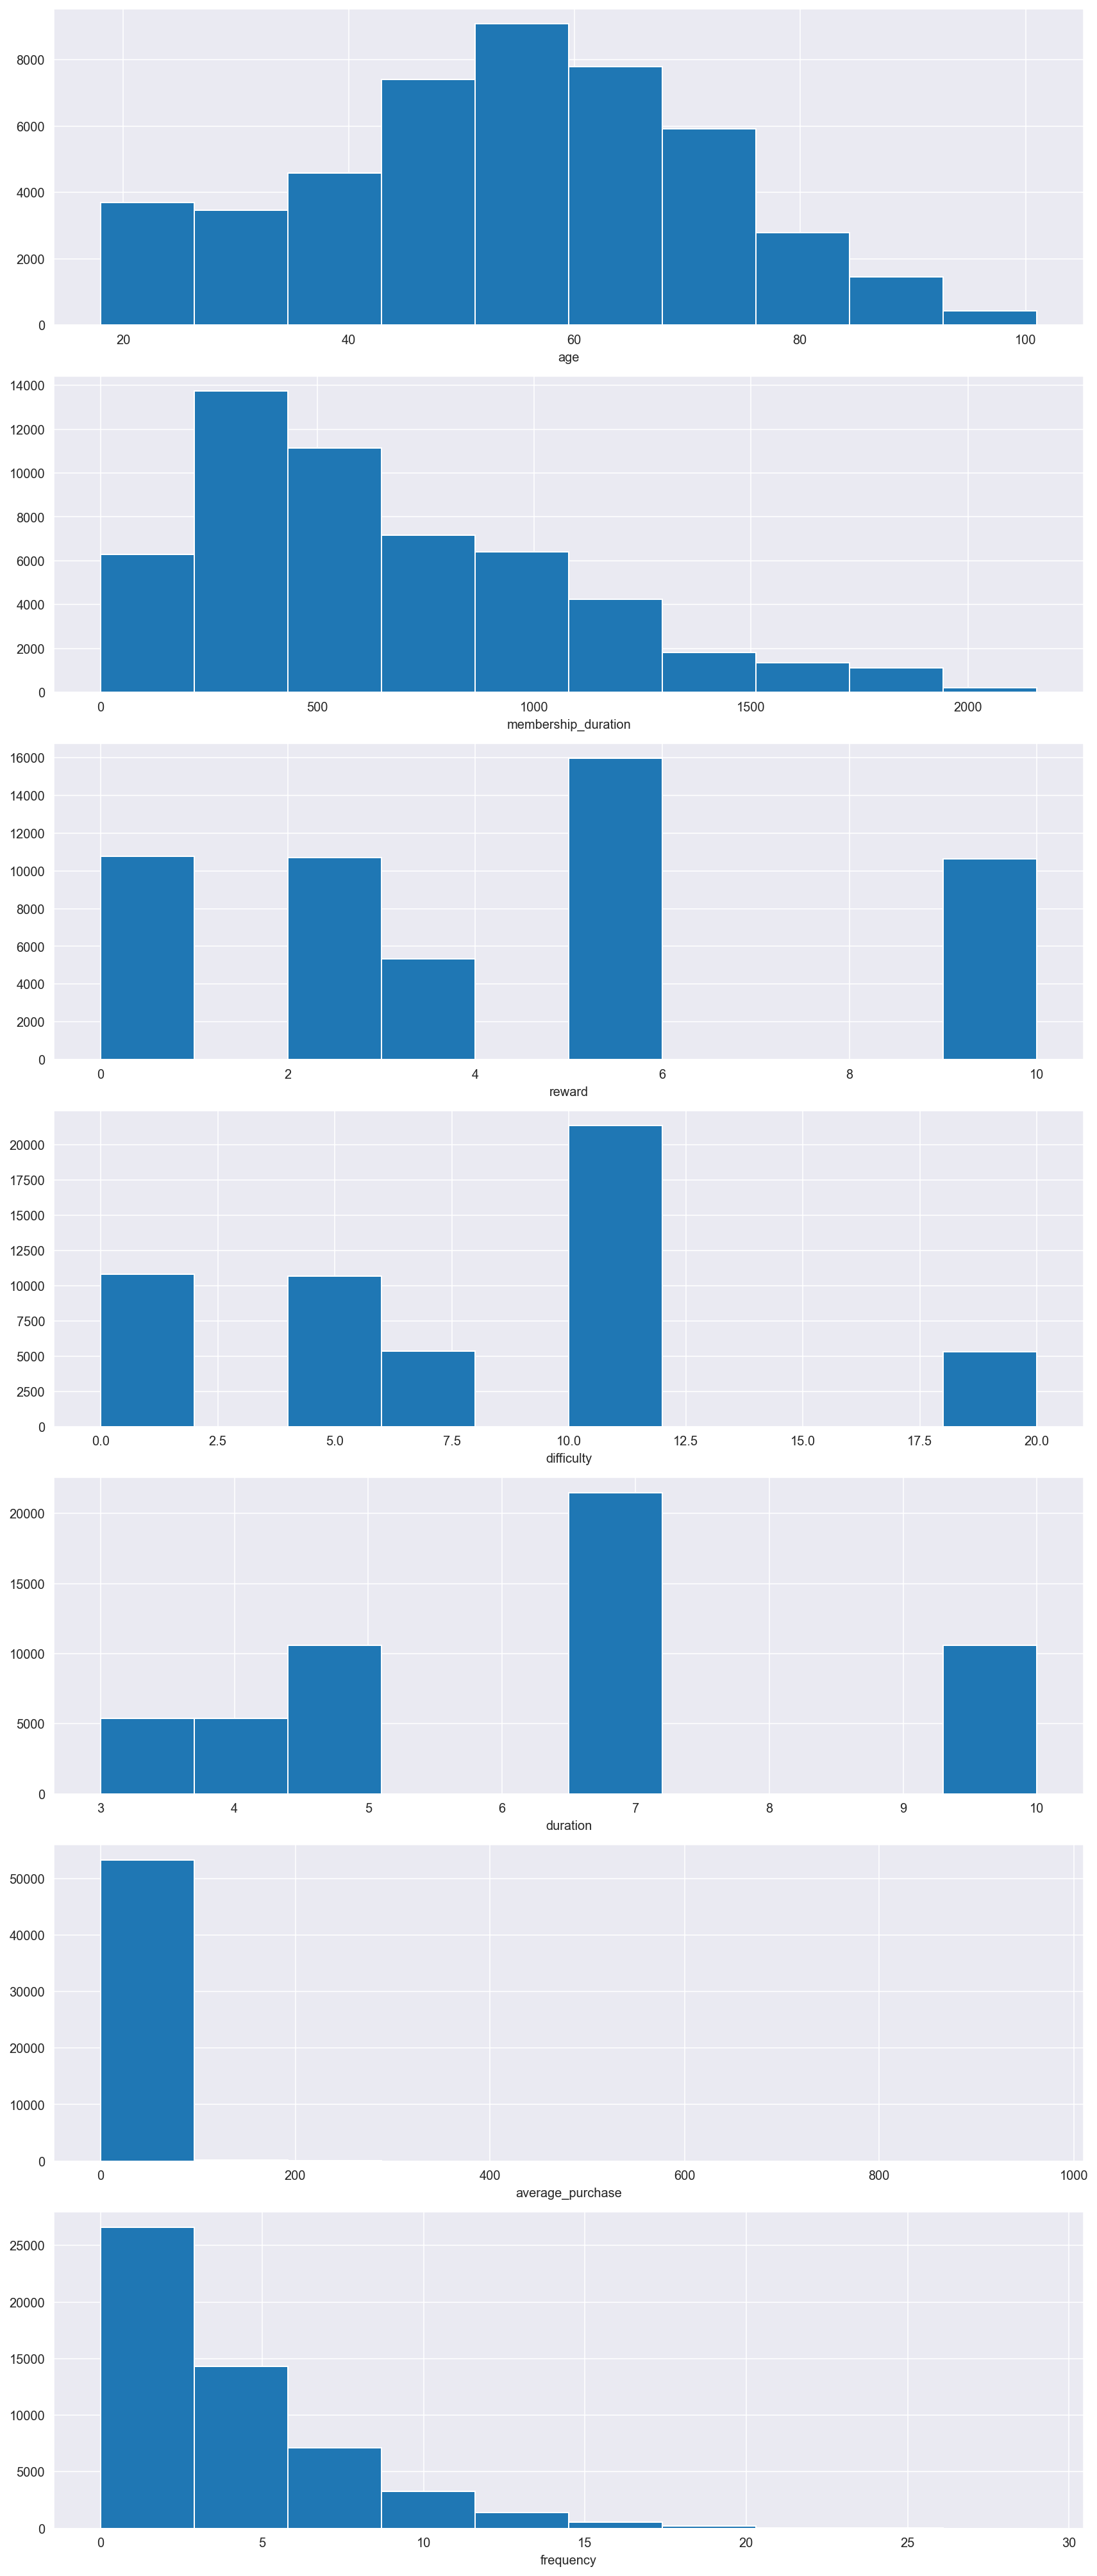

In [47]:
histogram(df_train, NUM_FEATURES)

##### Bivariate Analysis

* Numerical Features

In [48]:
def correlation_heatmap(data: pd.DataFrame, ref_col: str = None):
    """
    Function to display a correlation heatmap between numerical variables.
    
    Args: 
        data (pandas dataframe): dataframe containing the actual data
        ref_col (str): optional column name to display single row.
    
    Returns: 
        None
    """
    corr = data.corr()
    if ref_col is not None:
        corr = corr.loc[:, [ref_col]]
    mask = np.zeros_like(corr).astype(bool)
    mask[np.triu_indices_from(corr, k=1)] = True
    plt.figure(figsize=(8, 4))
    sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, mask=mask, cmap="coolwarm")
    plt.show()

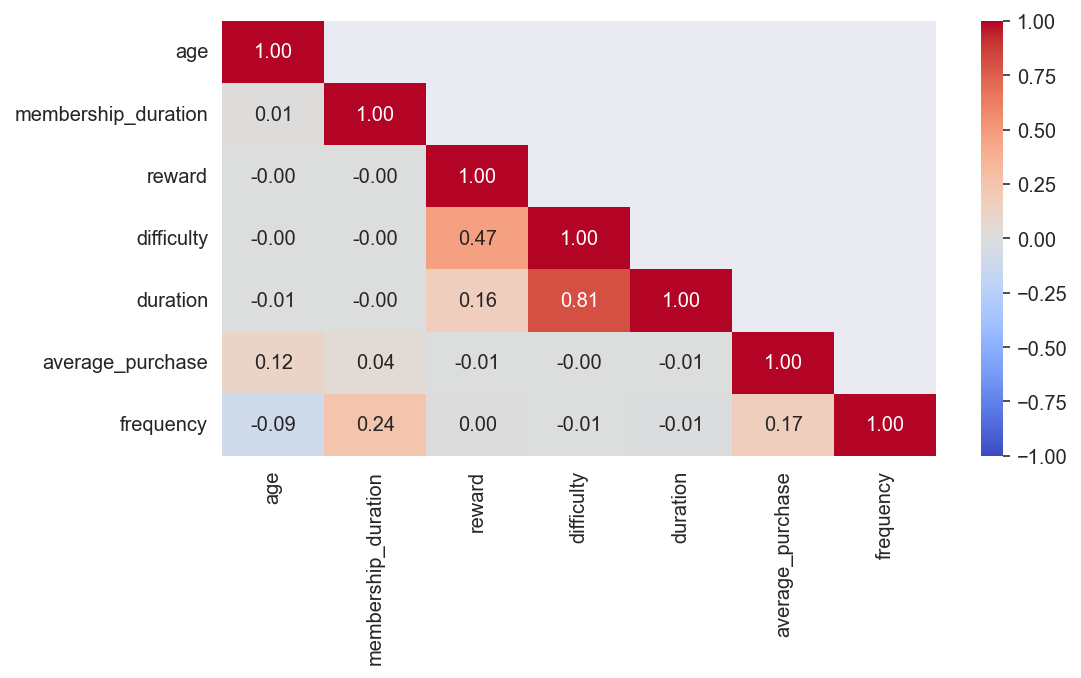

In [49]:
correlation_heatmap(df_train.loc[:, NUM_FEATURES])

From the correlation heatmap above, the only **highly-correlated pair** is `difficulty` and `duration`. Therefore, depending on the behavior of our target according to both of them, we could decide to follow with only one of them.

* Target Feature

Our decision can be already taken based on the following visualization. It is clear how `difficulty` discriminates more against the target variable.

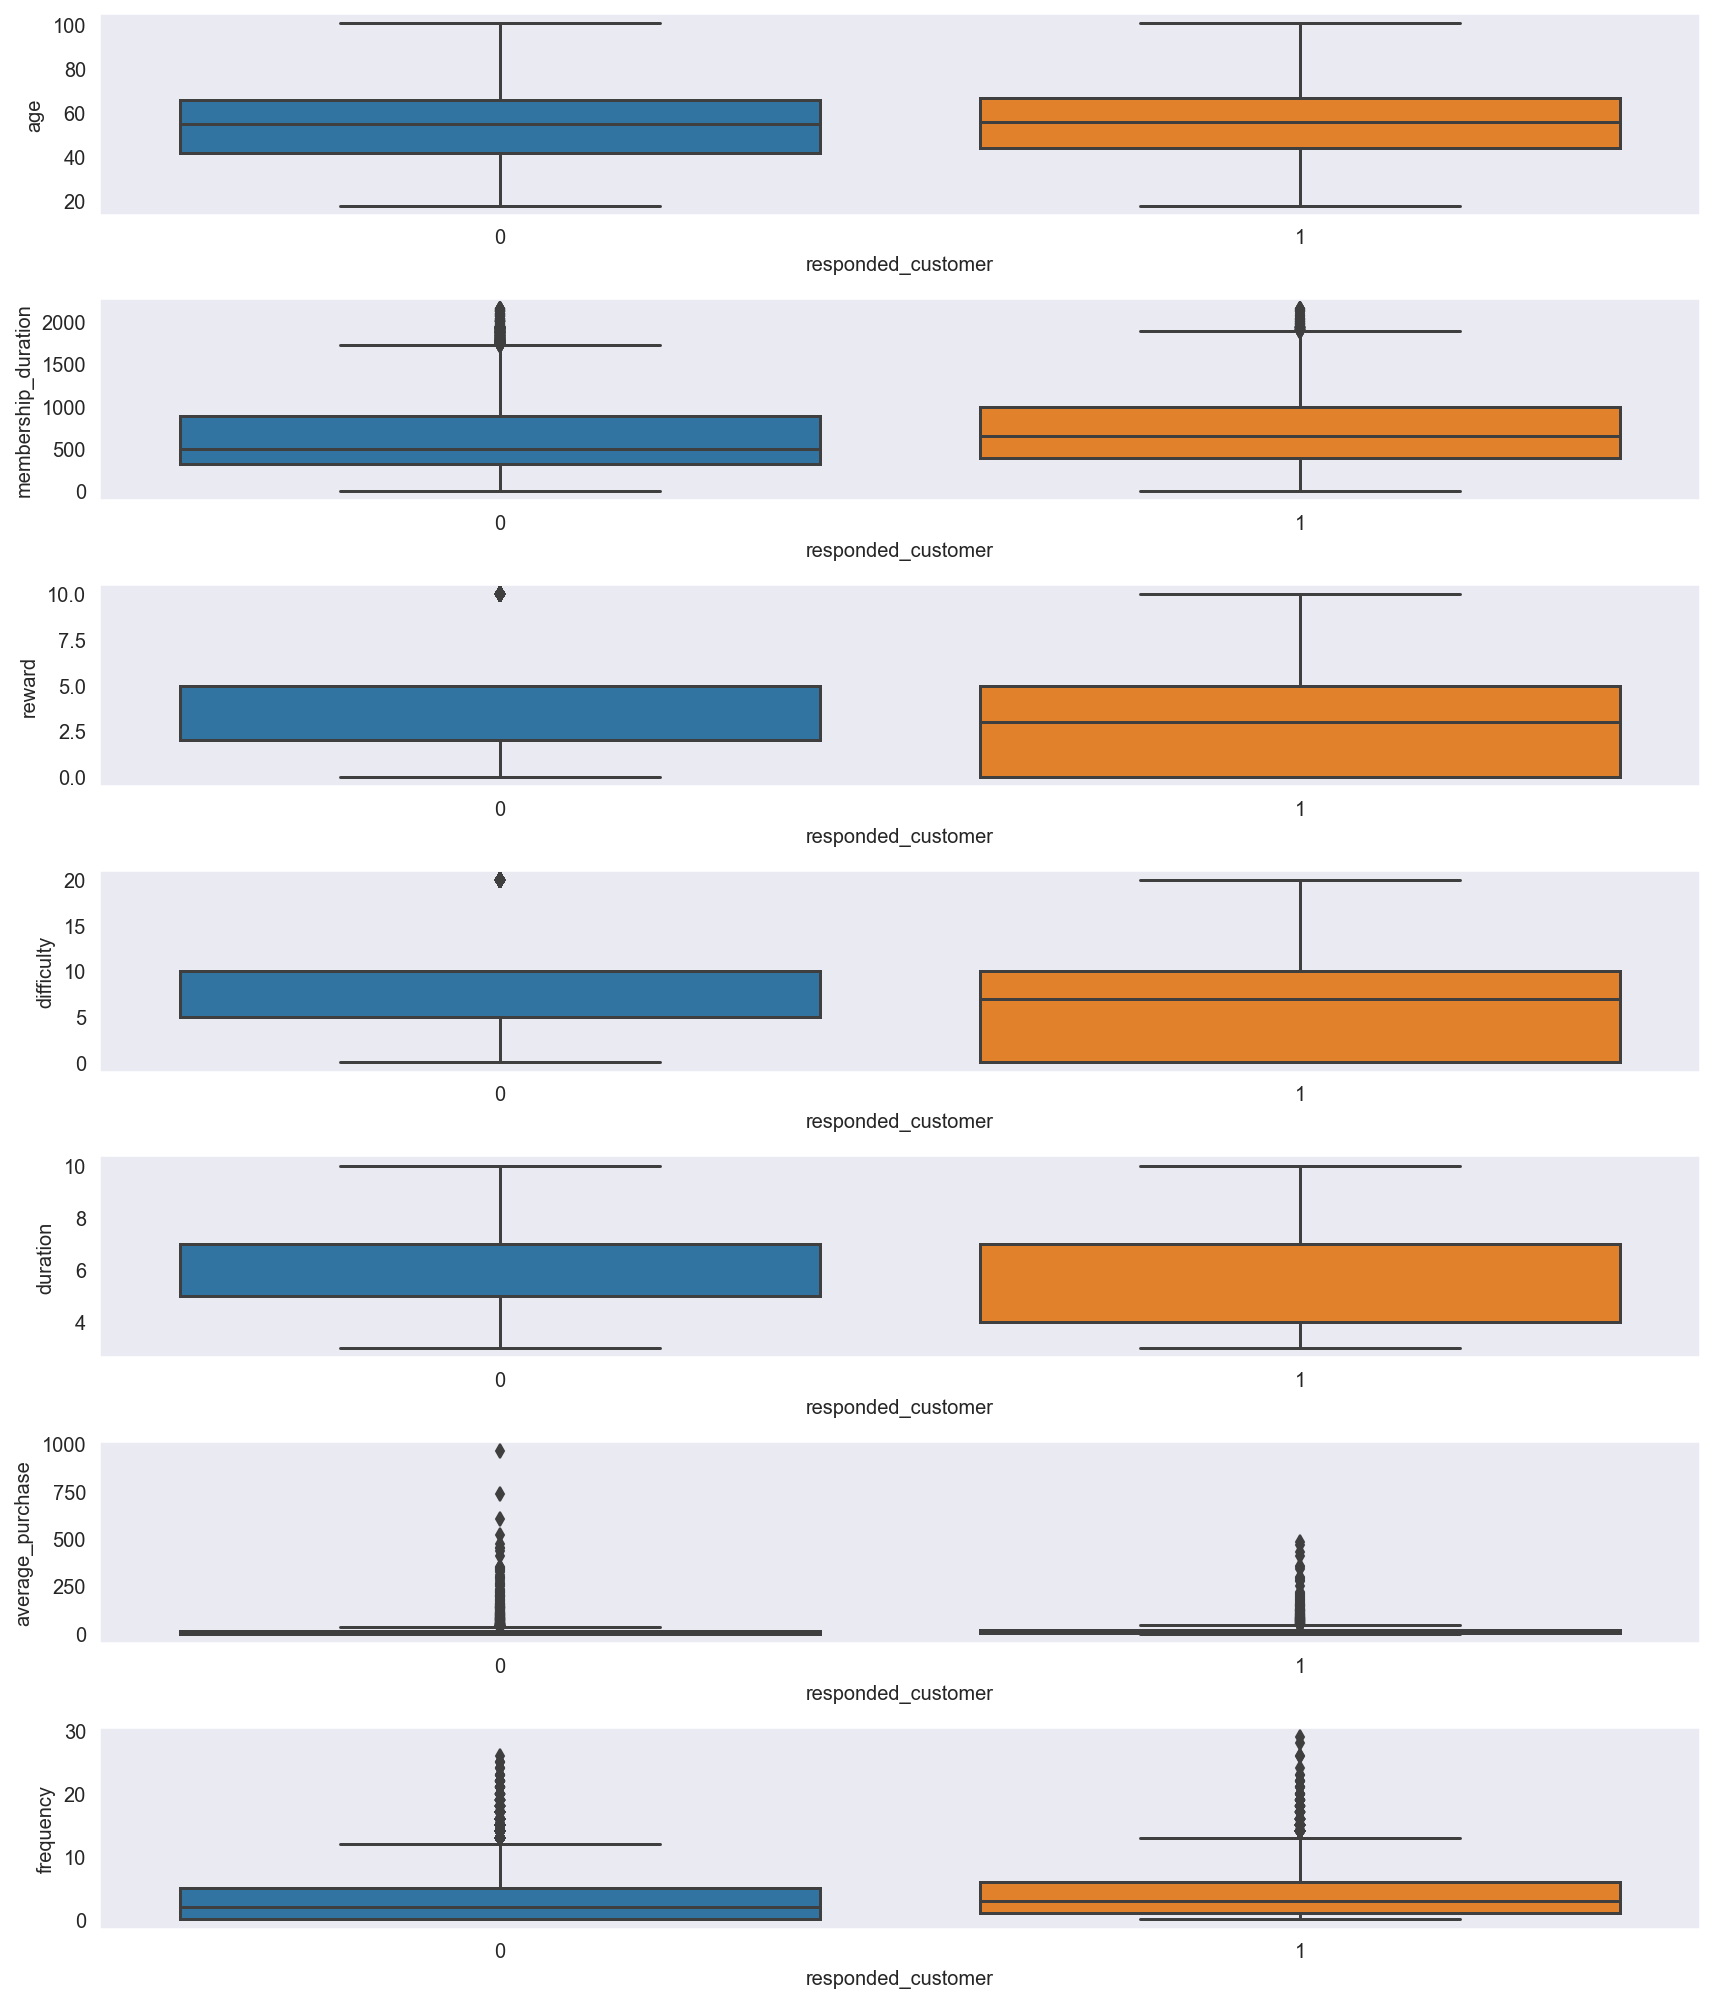

In [50]:
boxplot(df_train, NUM_FEATURES, by=TARGET)

+ Categorical Variables

Regarding `gender`, there is no much difference in how variables are distributed.

On the other hand, we can notice that long-term users tend to respond to promotional offers regardless of the reward, as long as they do not require a high amount to be spent.

[GENDER]


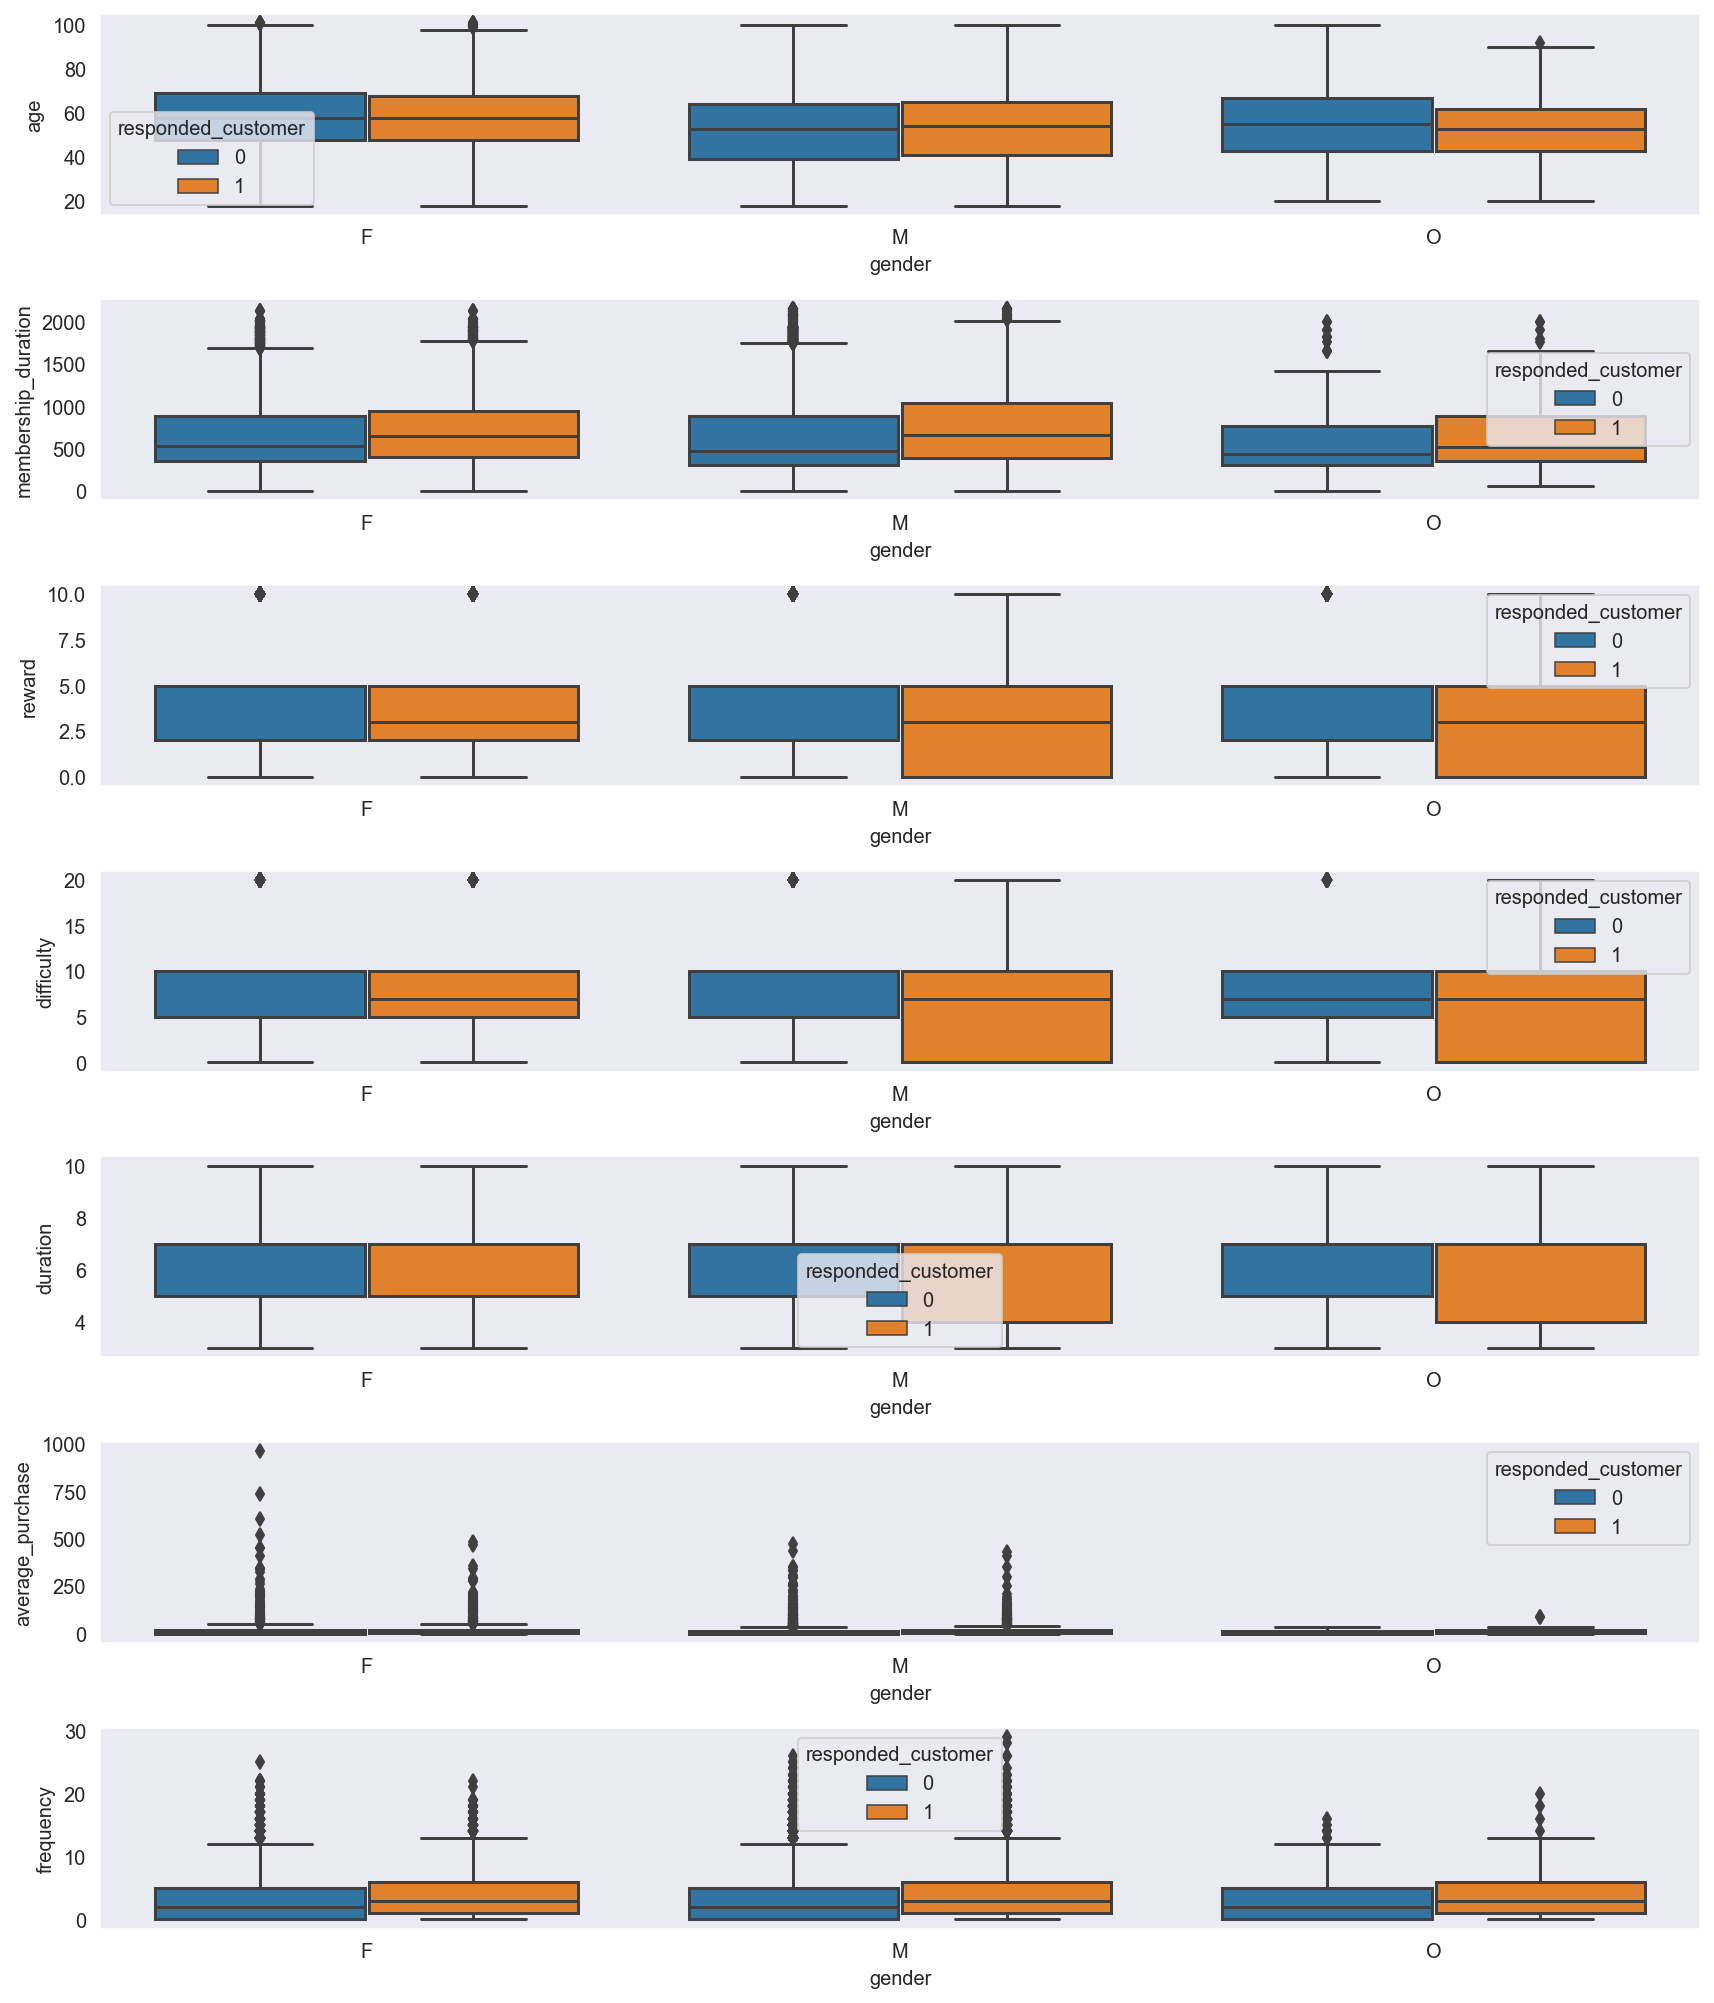

[OFFER_TYPE]


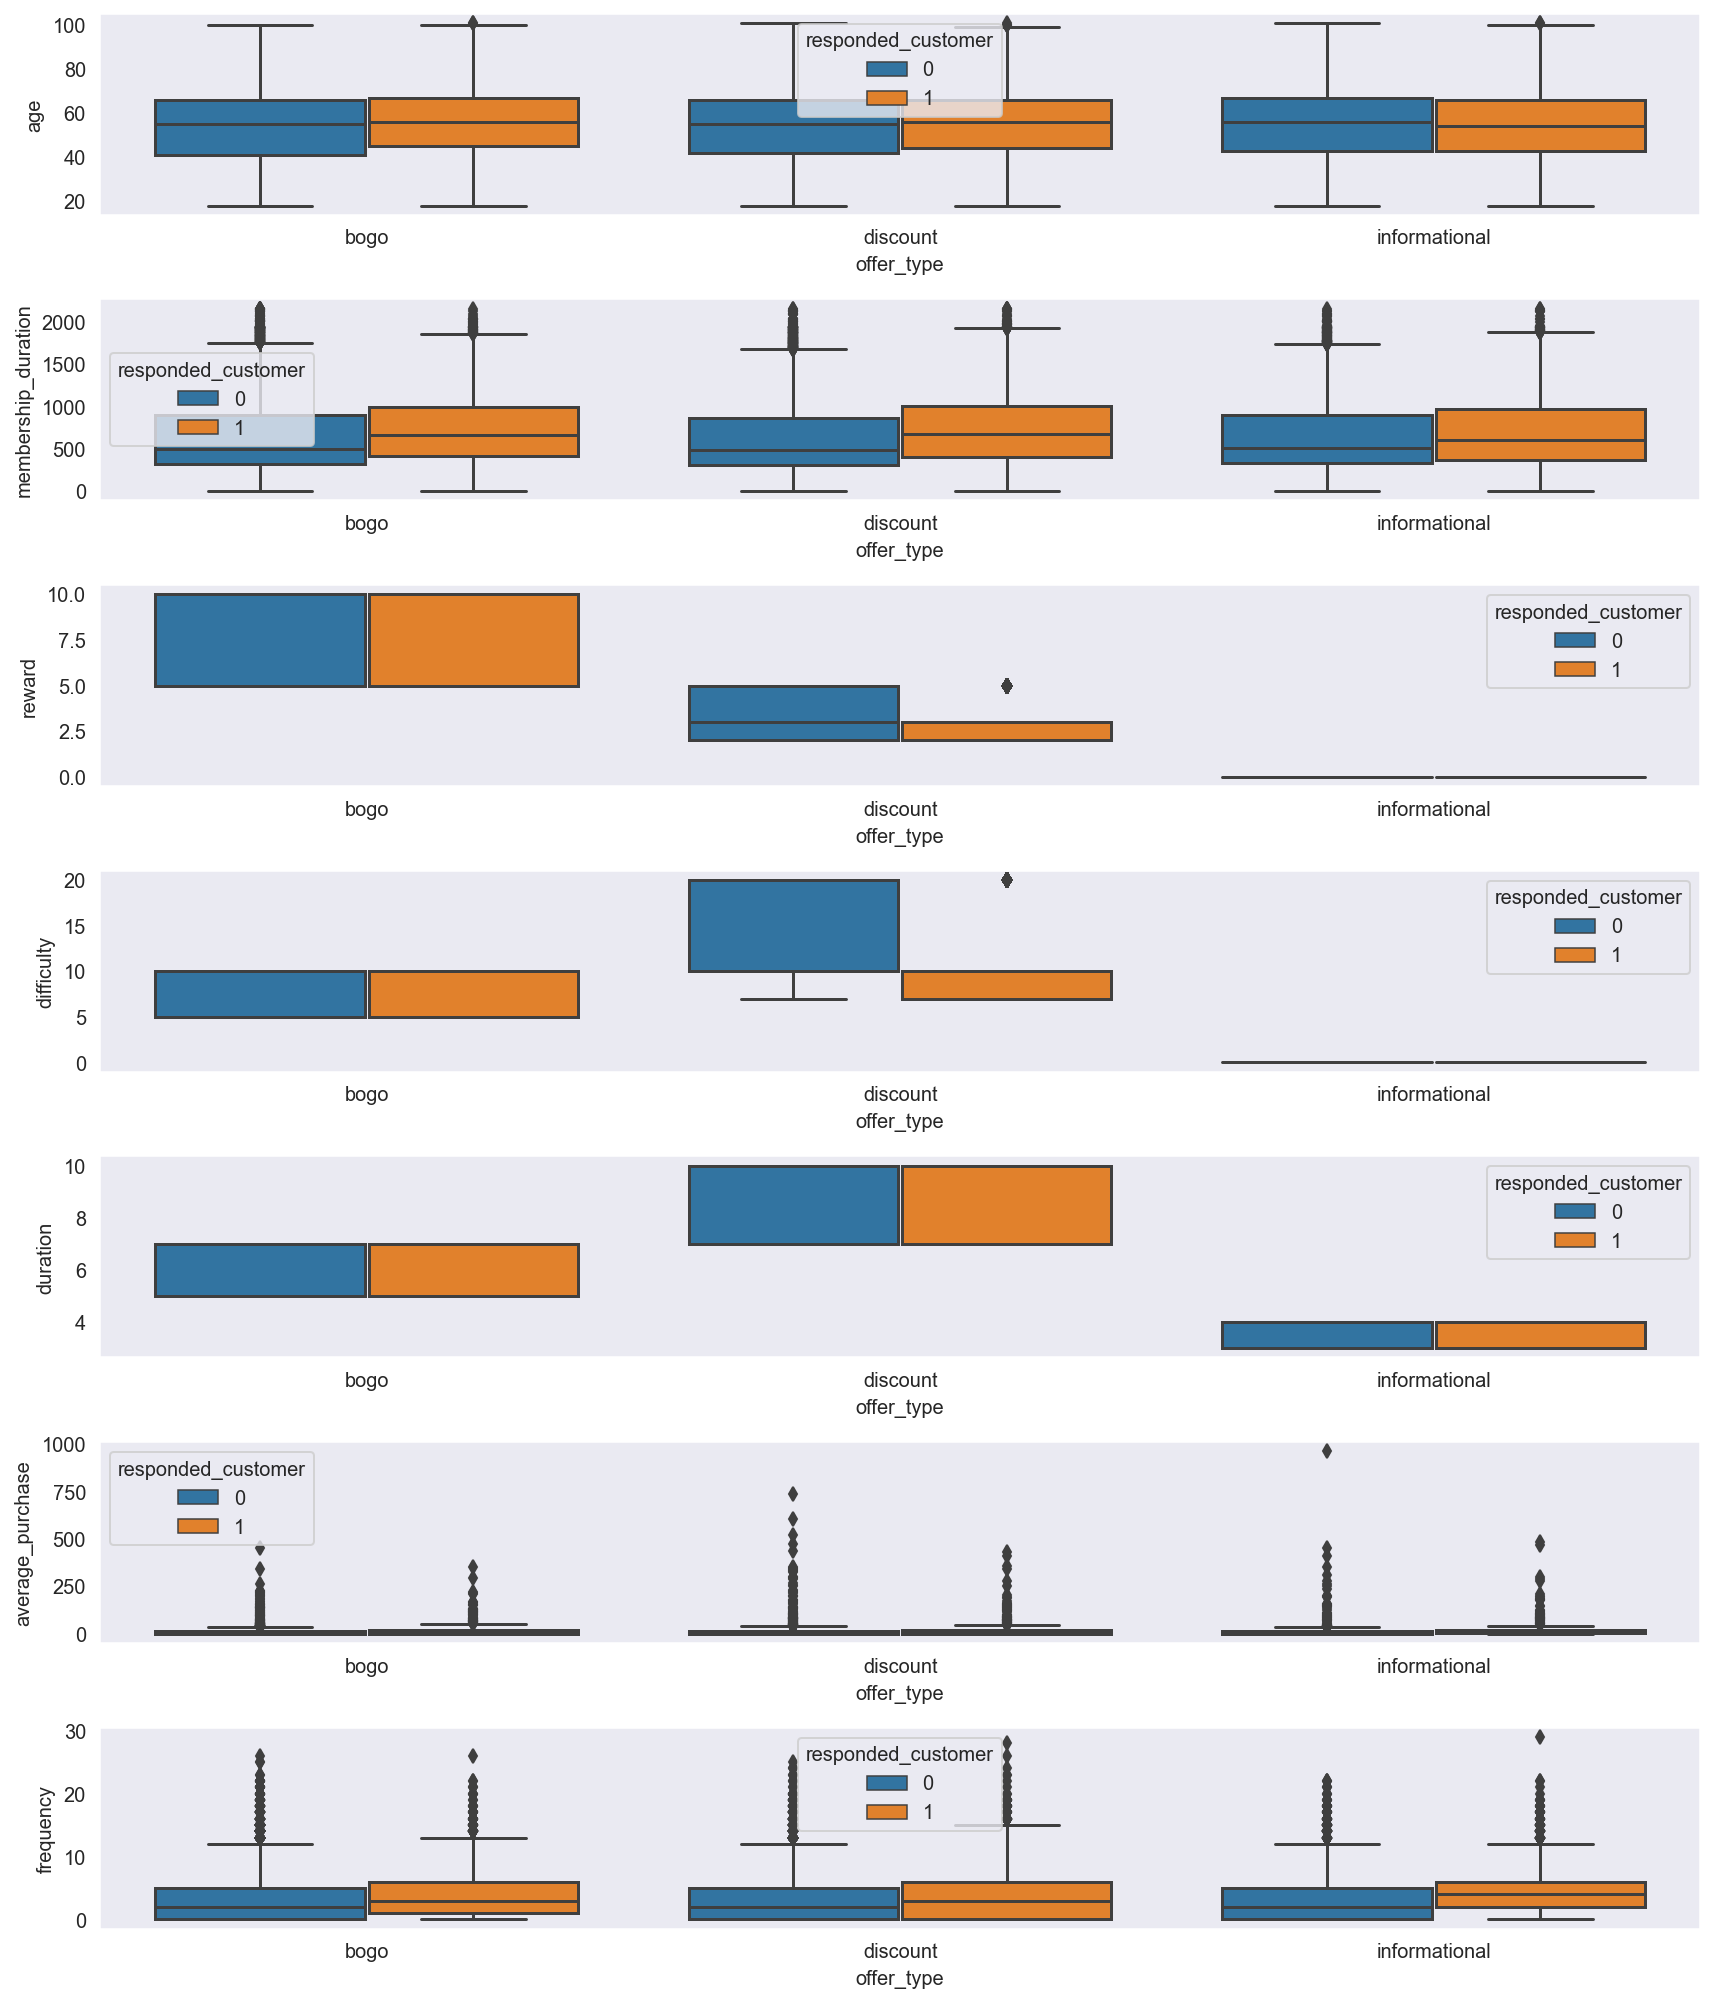

[WEB]


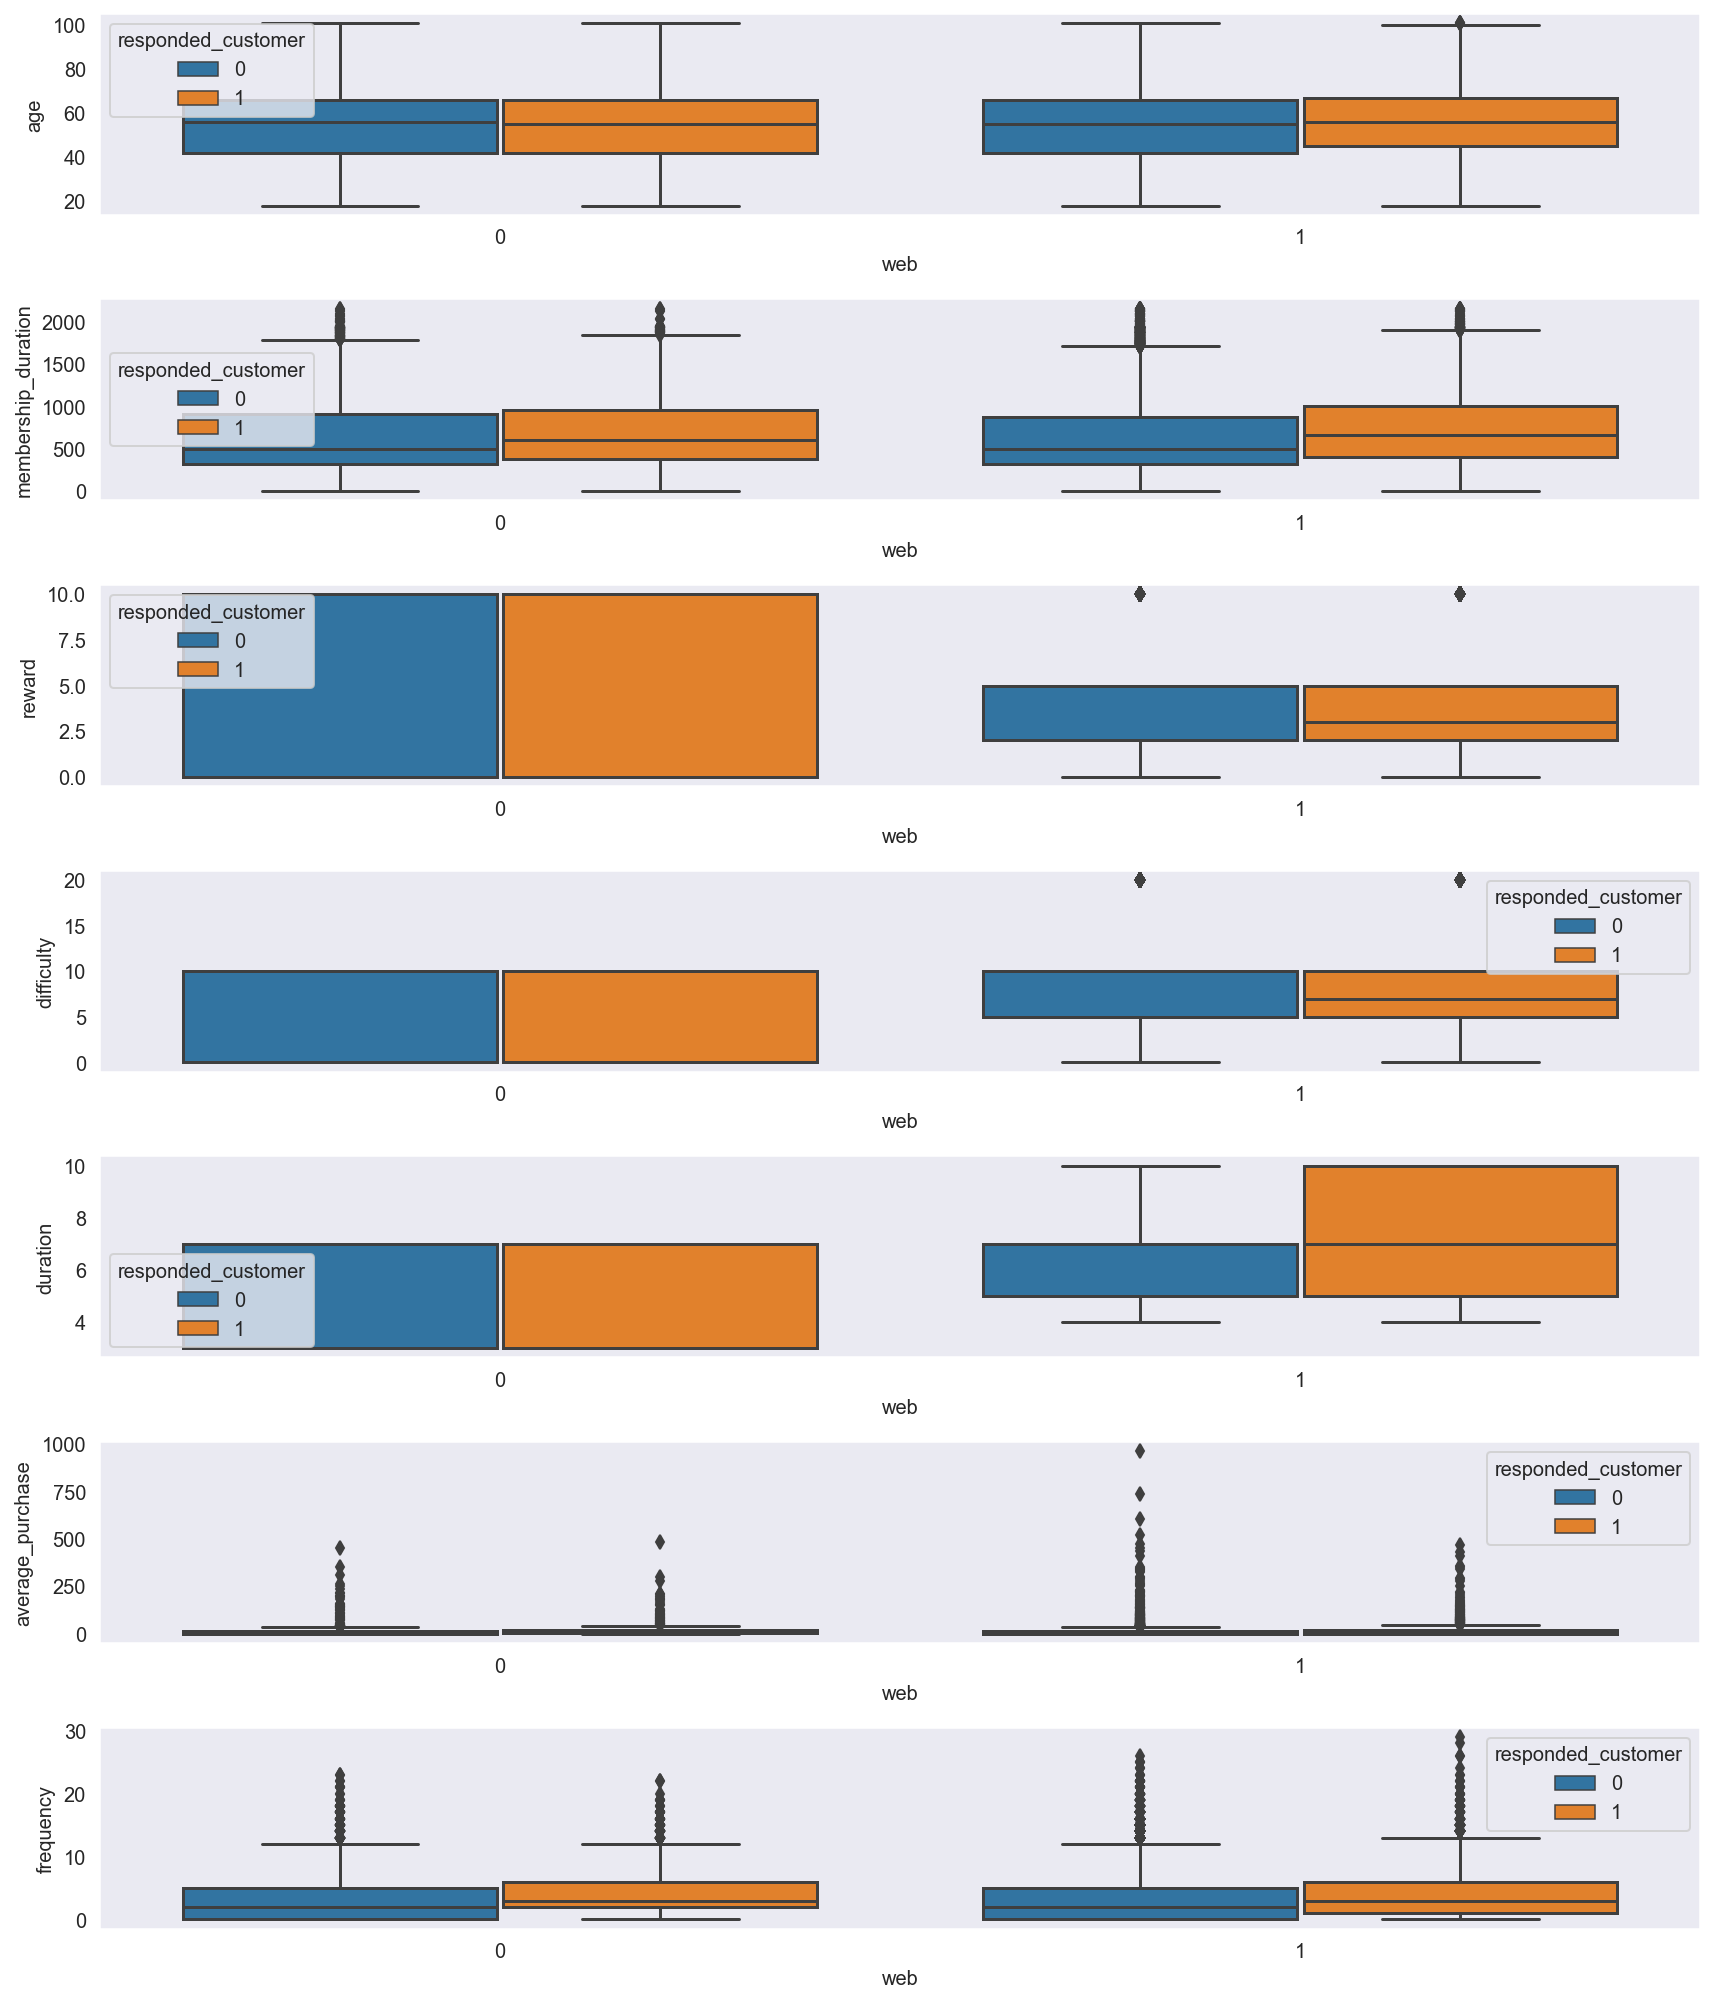

[EMAIL]


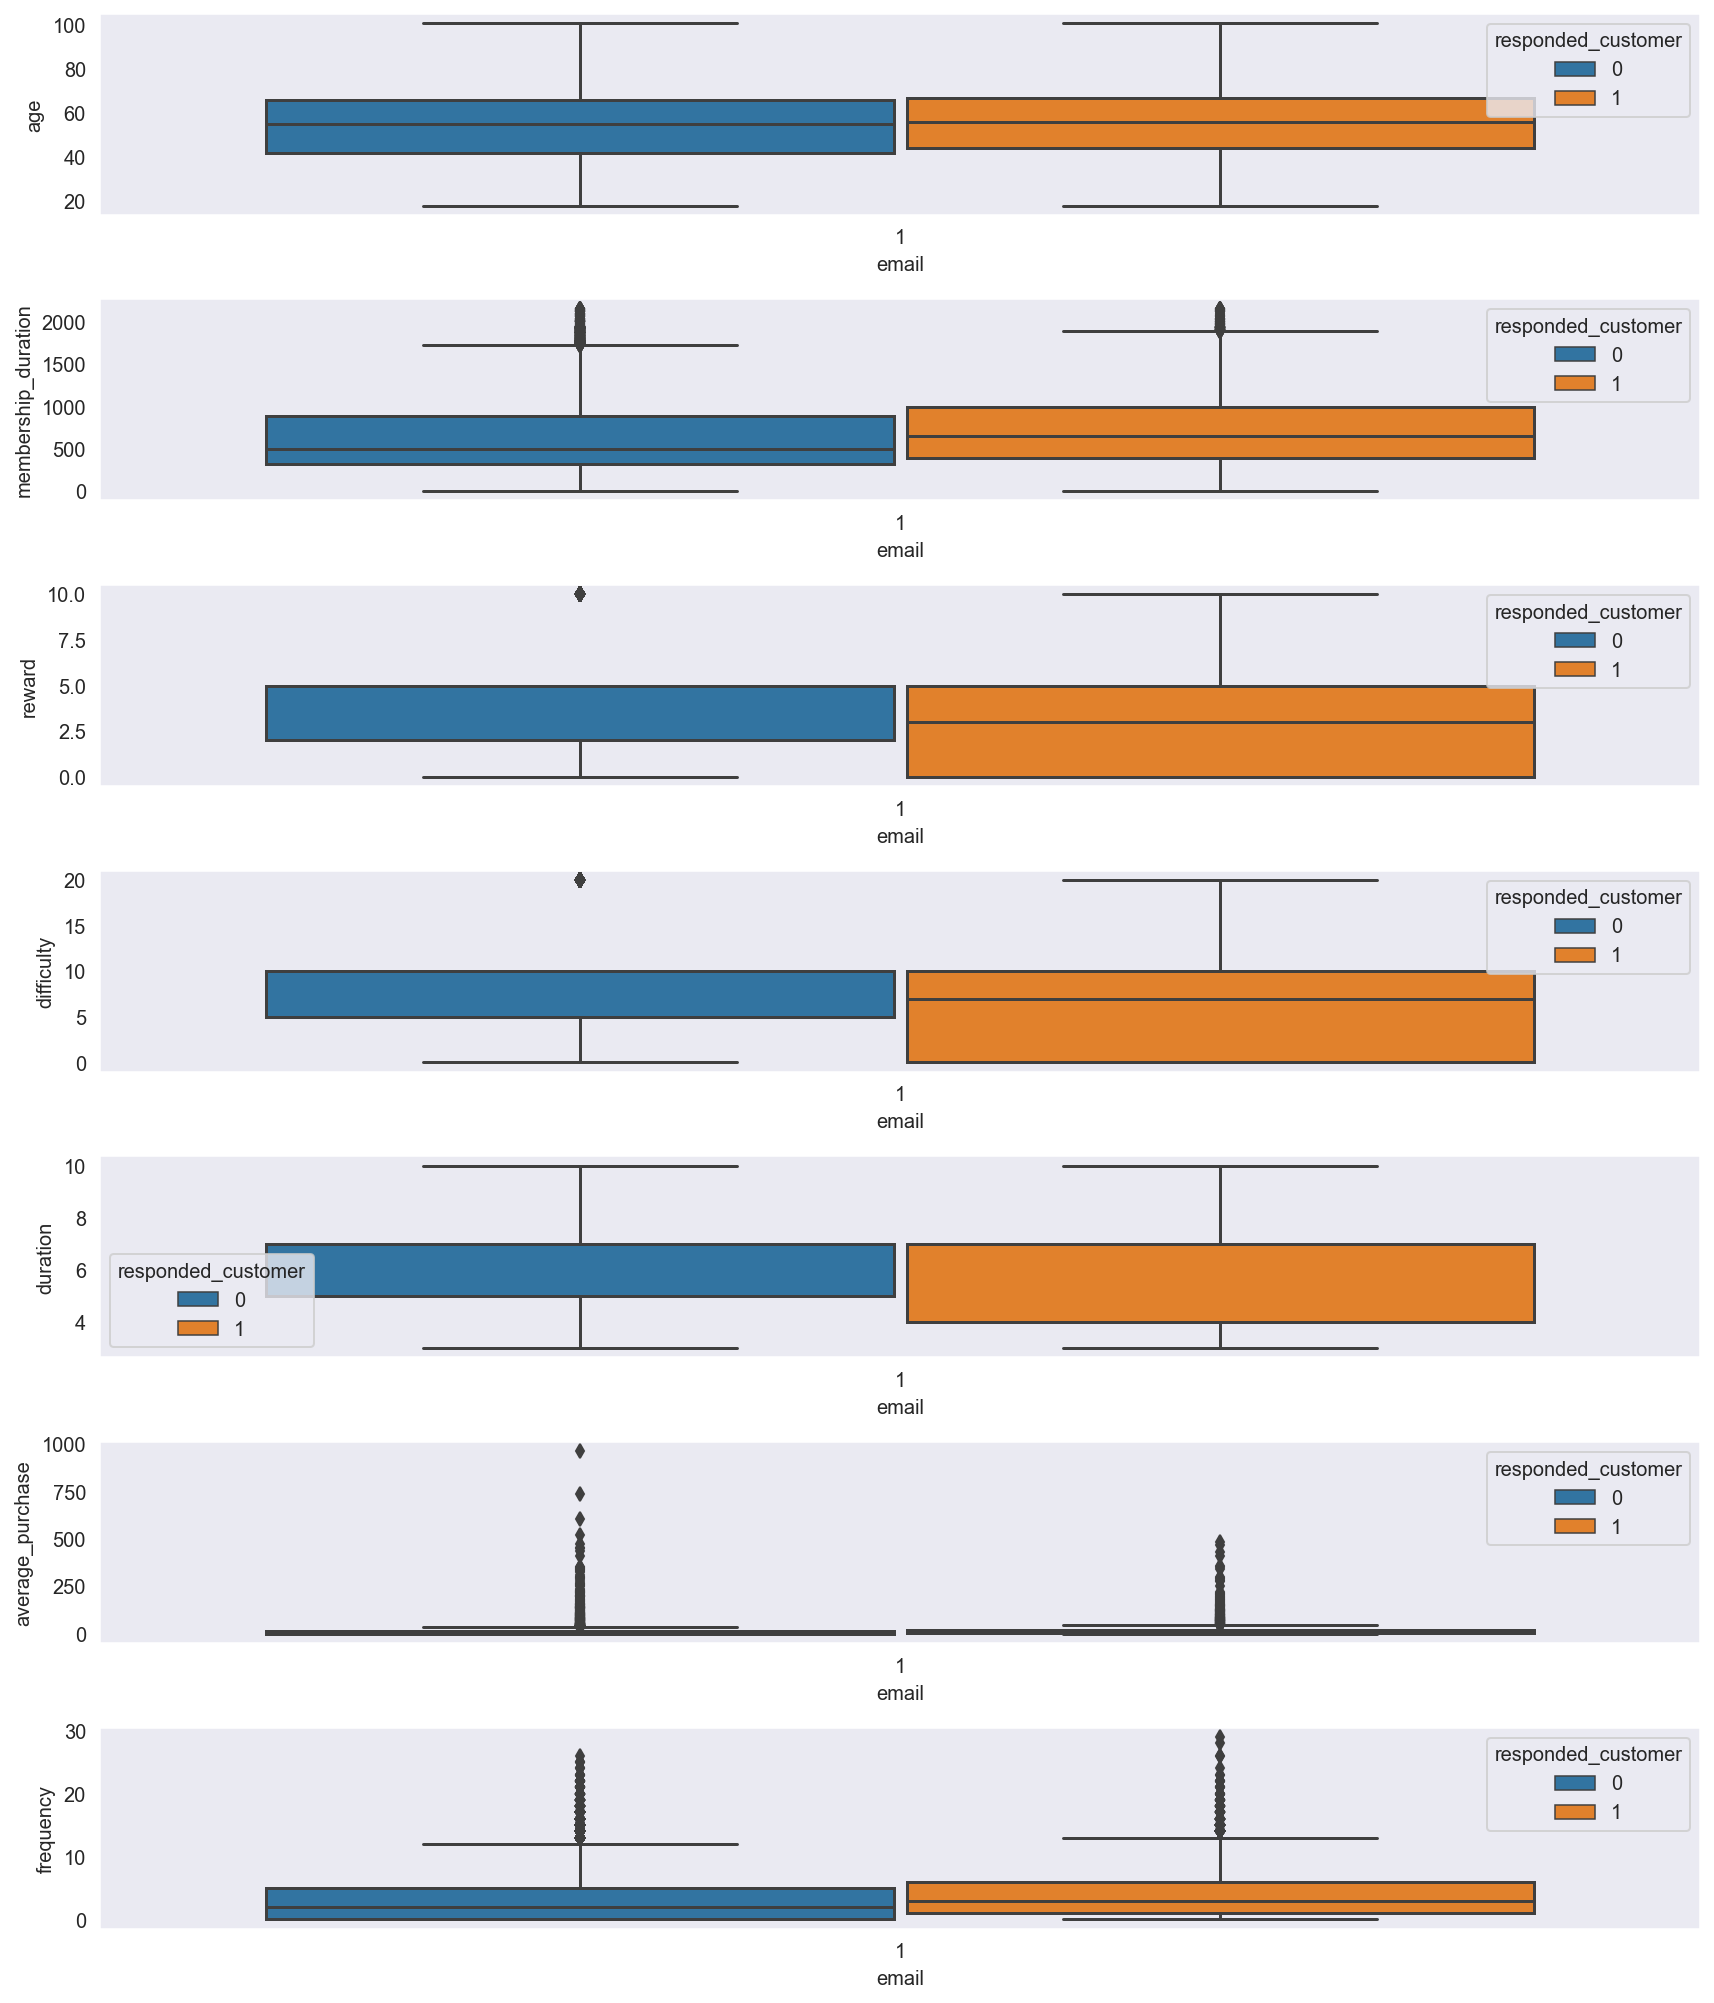

[MOBILE]


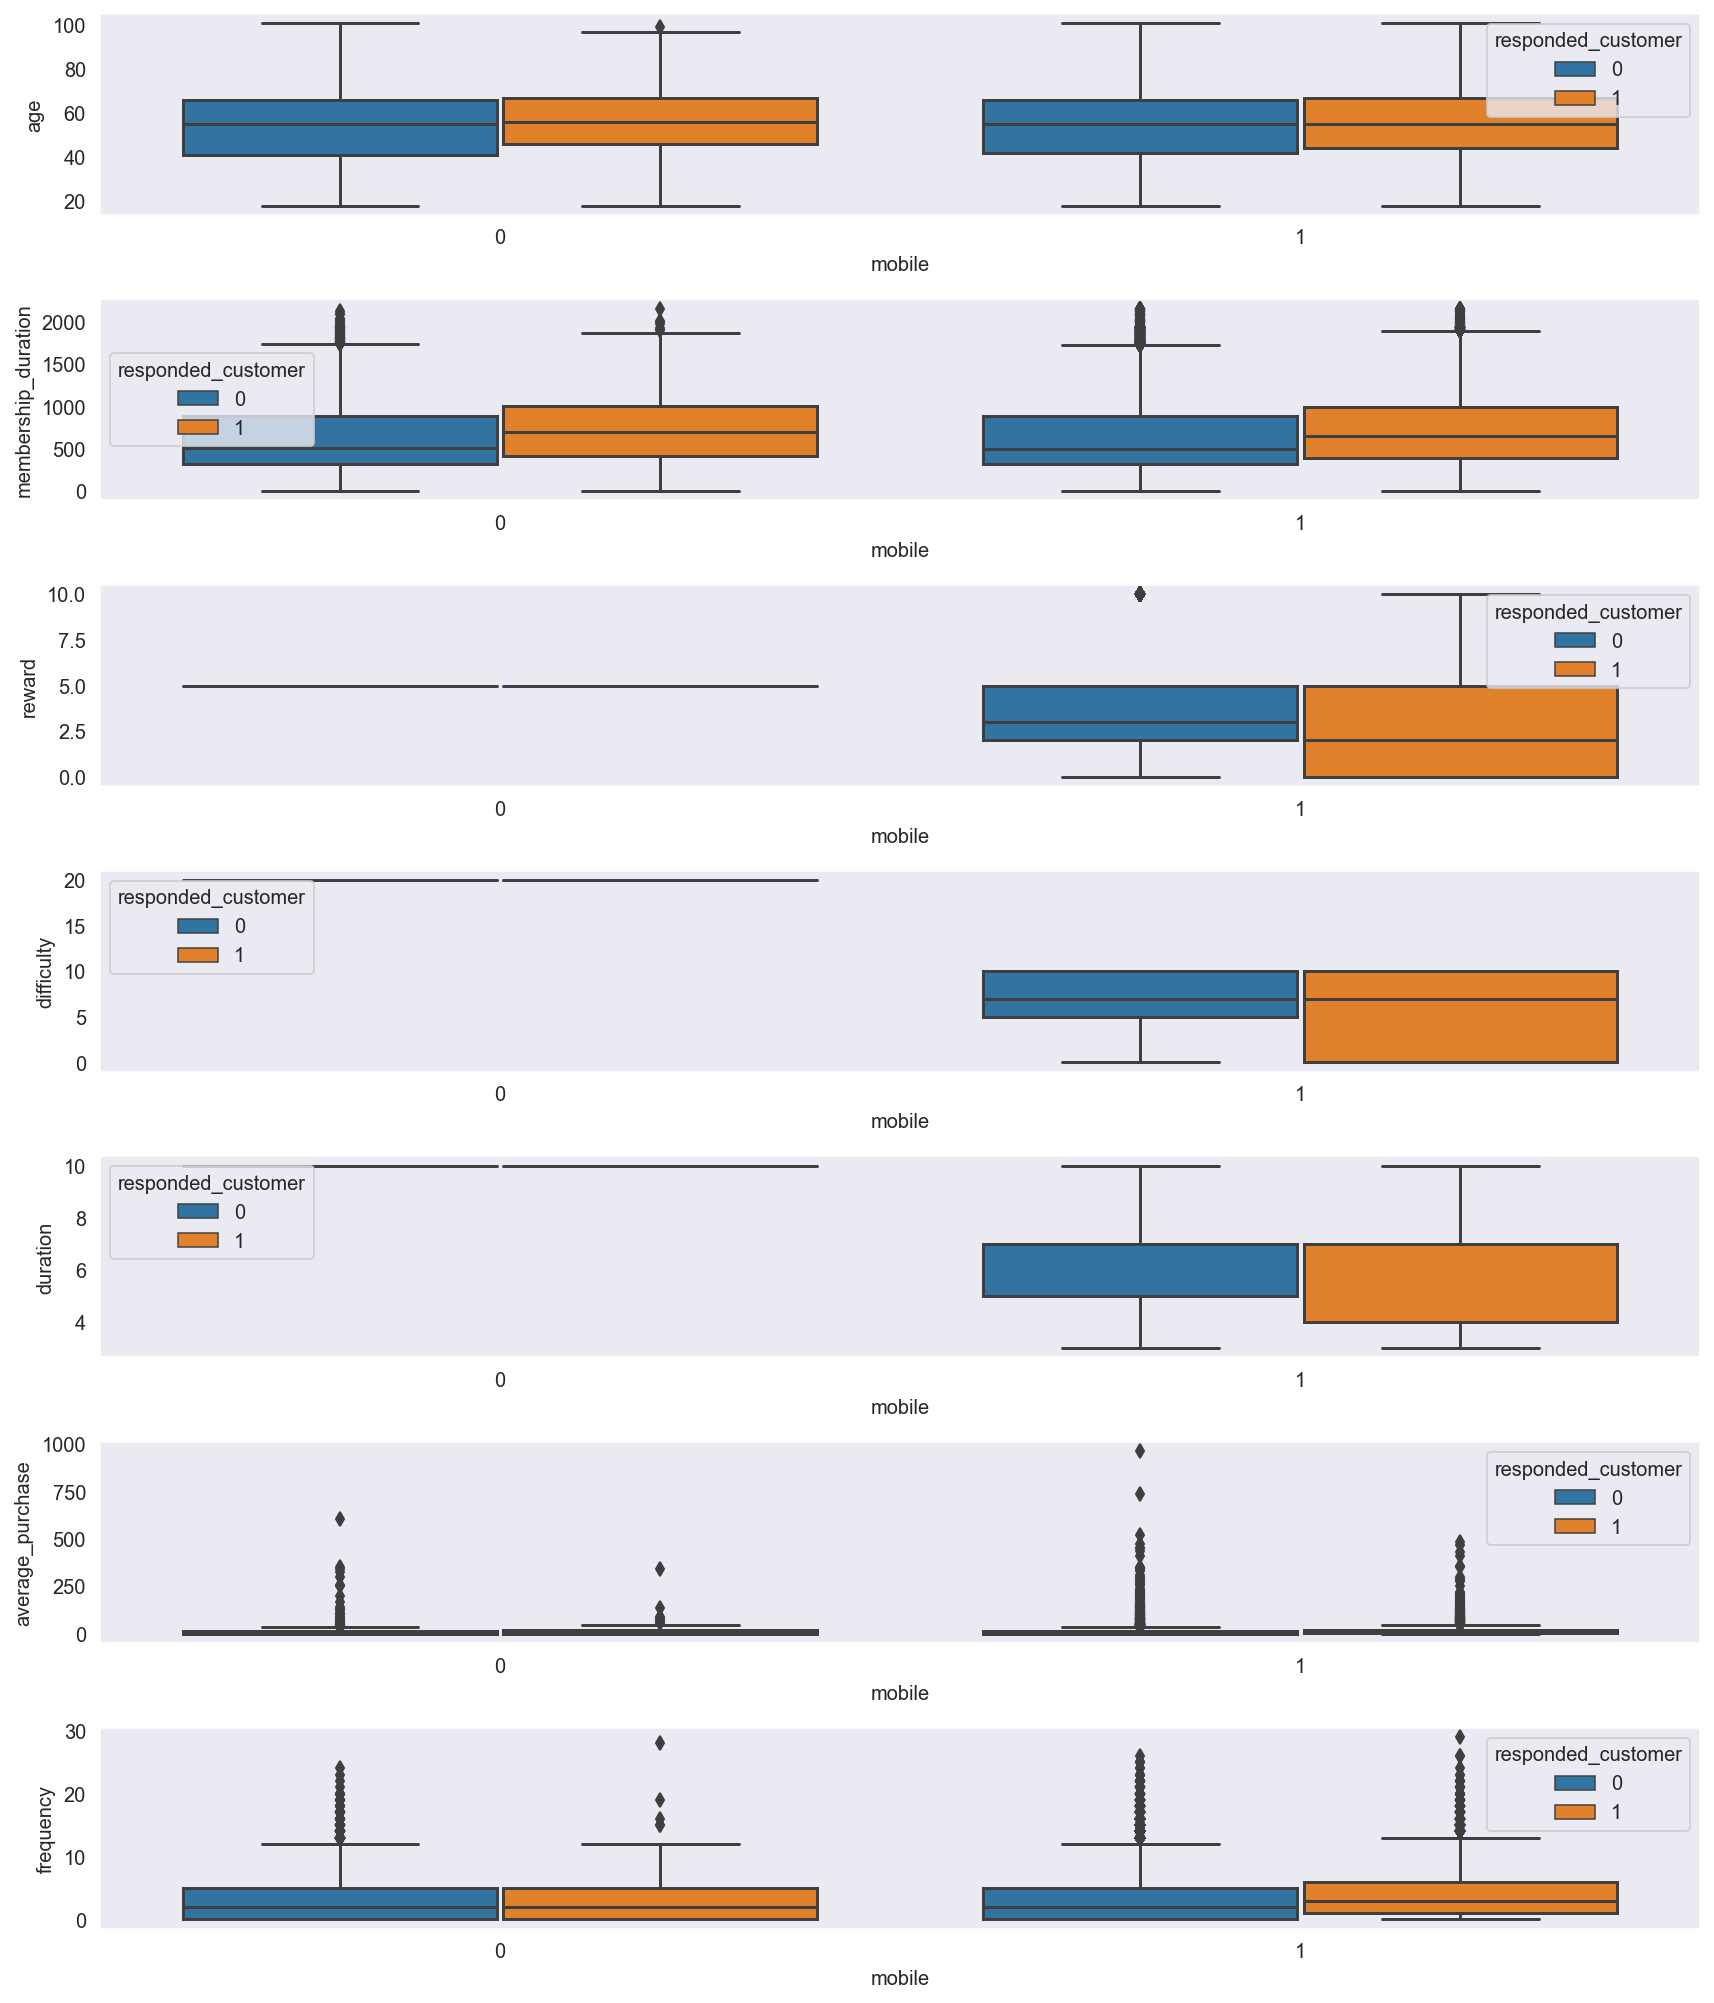

[SOCIAL]


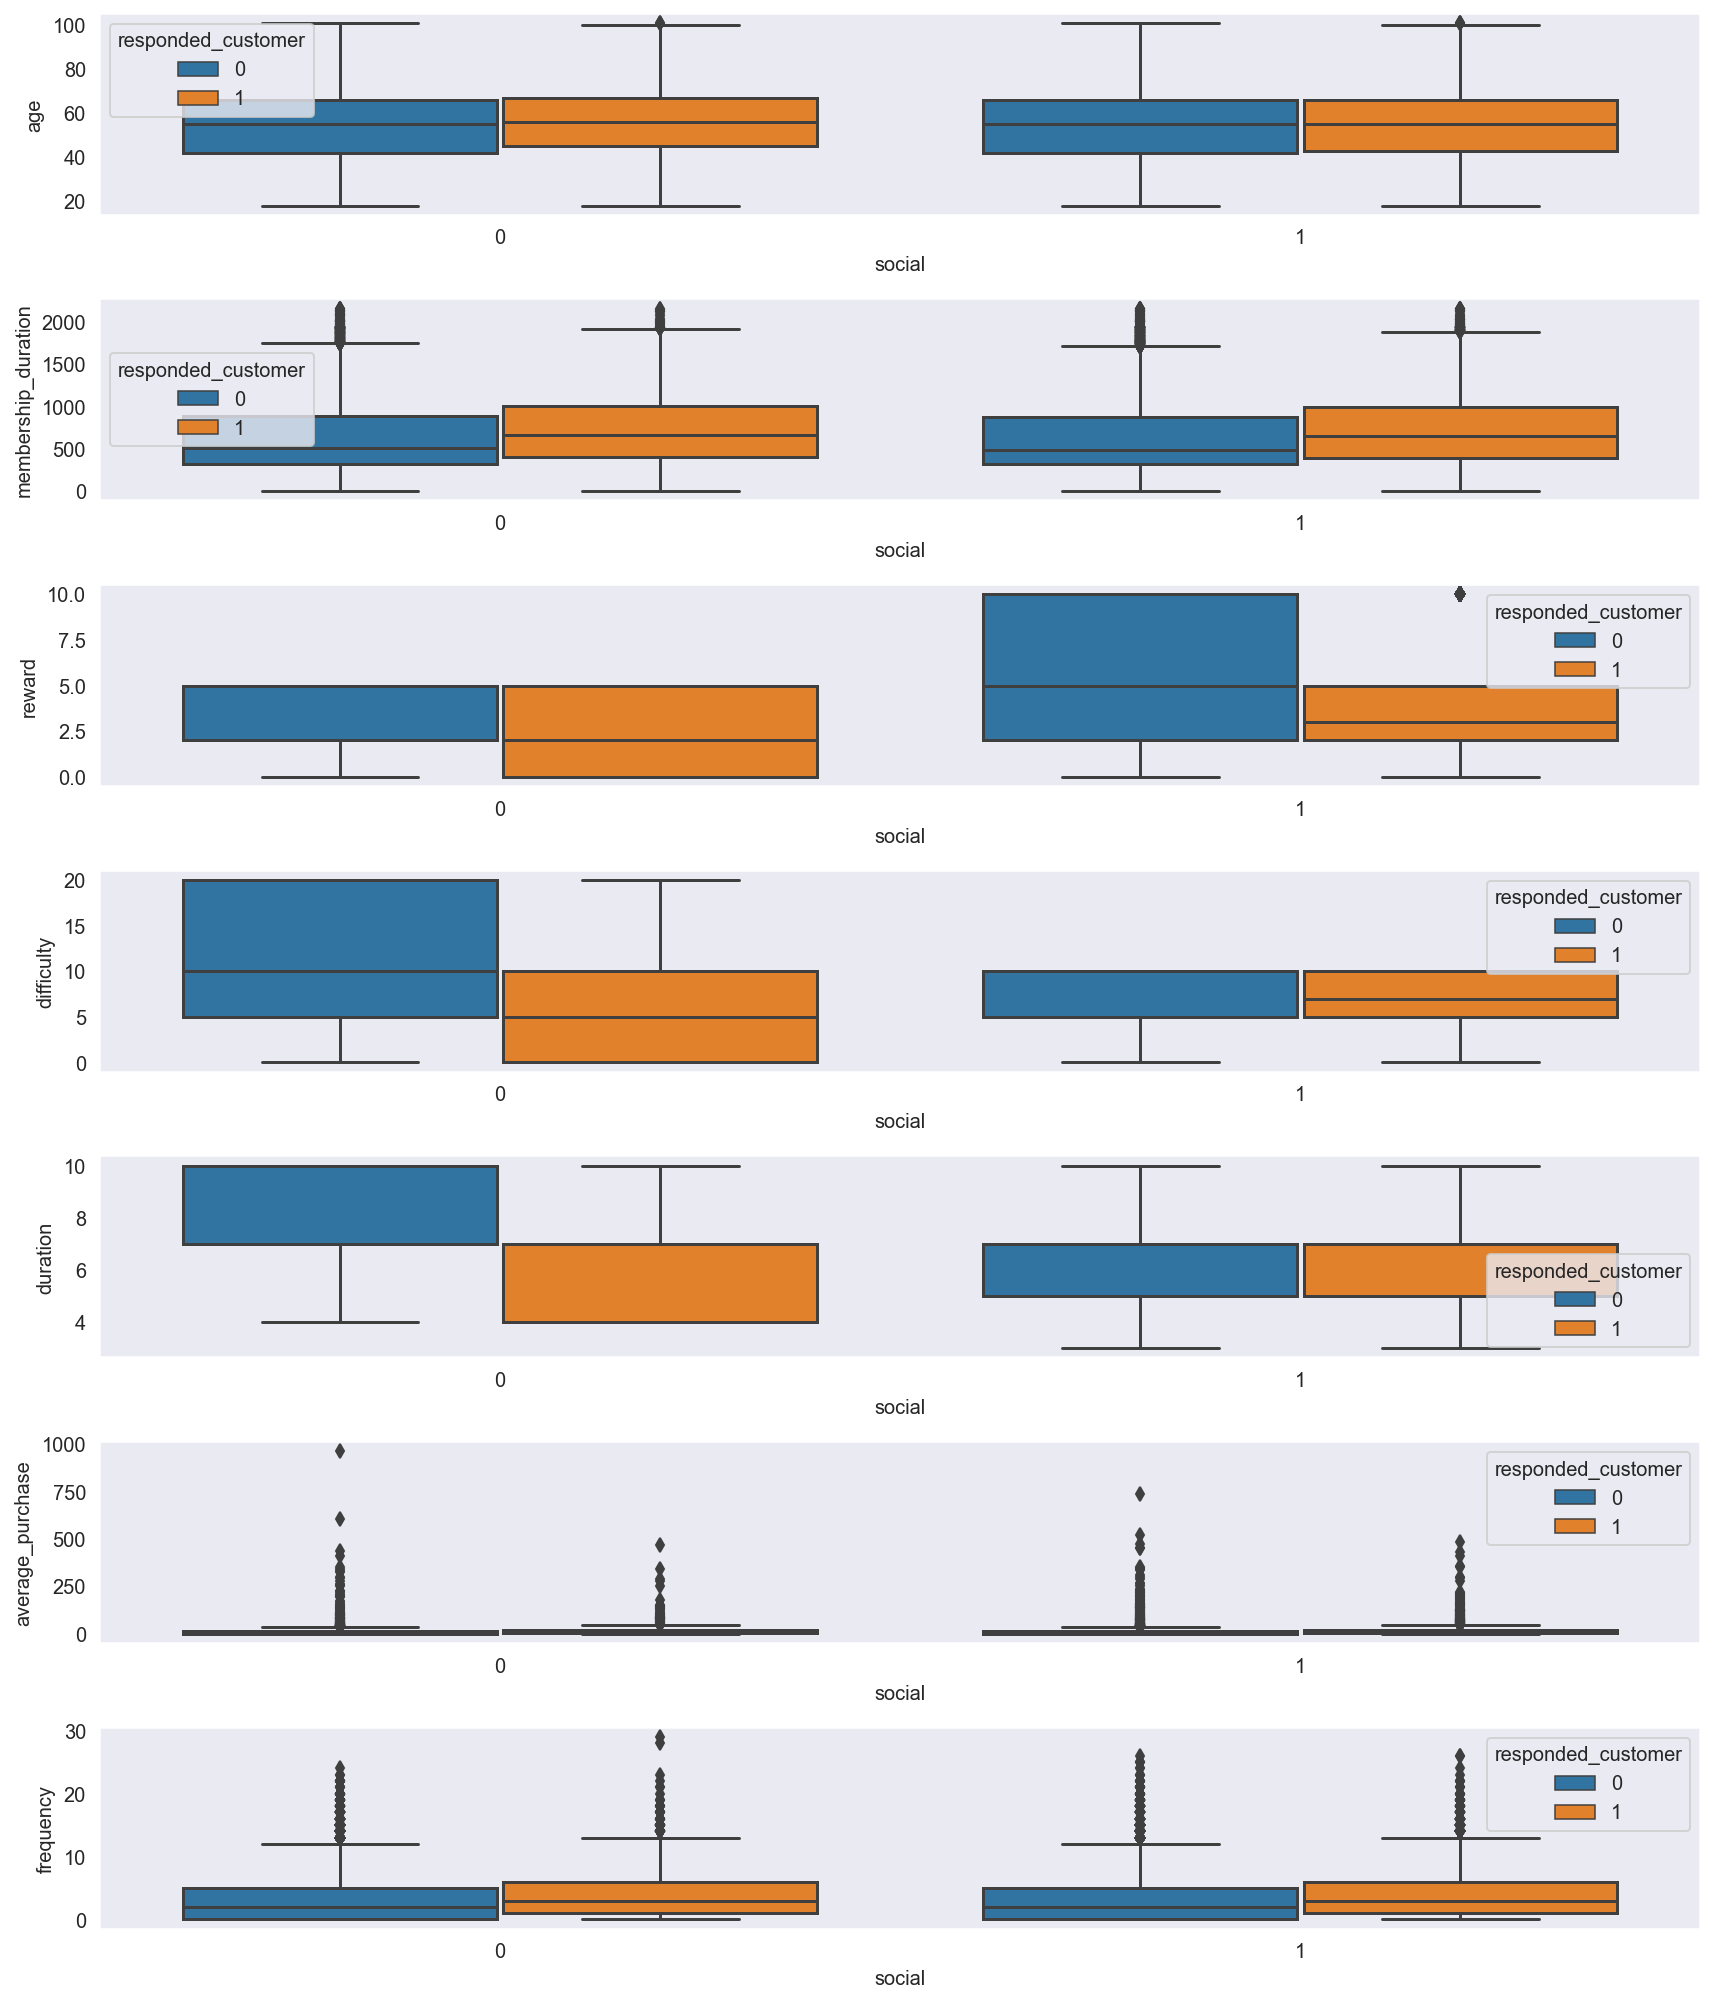

In [51]:
for cat in CAT_FEATURES:
    print(f"[{cat.upper()}]")
    boxplot(df_train, NUM_FEATURES, by=cat, hue=TARGET)

#### 4.3. Categorical Features

Finally, let's take a closer look at the categorical features.

##### Univariate Analysis

The majority of customers who took part in the 30-day test period are male, and the most common types of offers are BOGO and discount. Informational offers were less often used in this context.

In [52]:
def countplot(data: pd.DataFrame, cat_cols: List[str], hue: str = None):
    """
    Function to plot countplots for either univariate or bivariate statistical analysis.
    
    Args: 
        data (pandas dataframe): dataframe containing the actual data
        cat_cols (list of str): categorical columns whose boxplots will be displayed
        hue (str): optional categorical column to discriminate the data further
    
    Returns: 
        None
    """
    multiplier = 2
    if hue is not None:
        multiplier = max([multiplier, df.loc[:, hue].nunique()])
    plt.figure(figsize=(12, multiplier*len(cat_cols)))
    for i, cat_col in enumerate(cat_cols):
        ax = plt.subplot(len(cat_cols), 1, i+1)
        if hue is not None:
            sns.countplot(y=cat_col, hue=hue, data=data, ax=ax)
        else:
            sns.countplot(x=cat_col, data=data, ax=ax)
    plt.tight_layout()
    plt.show()

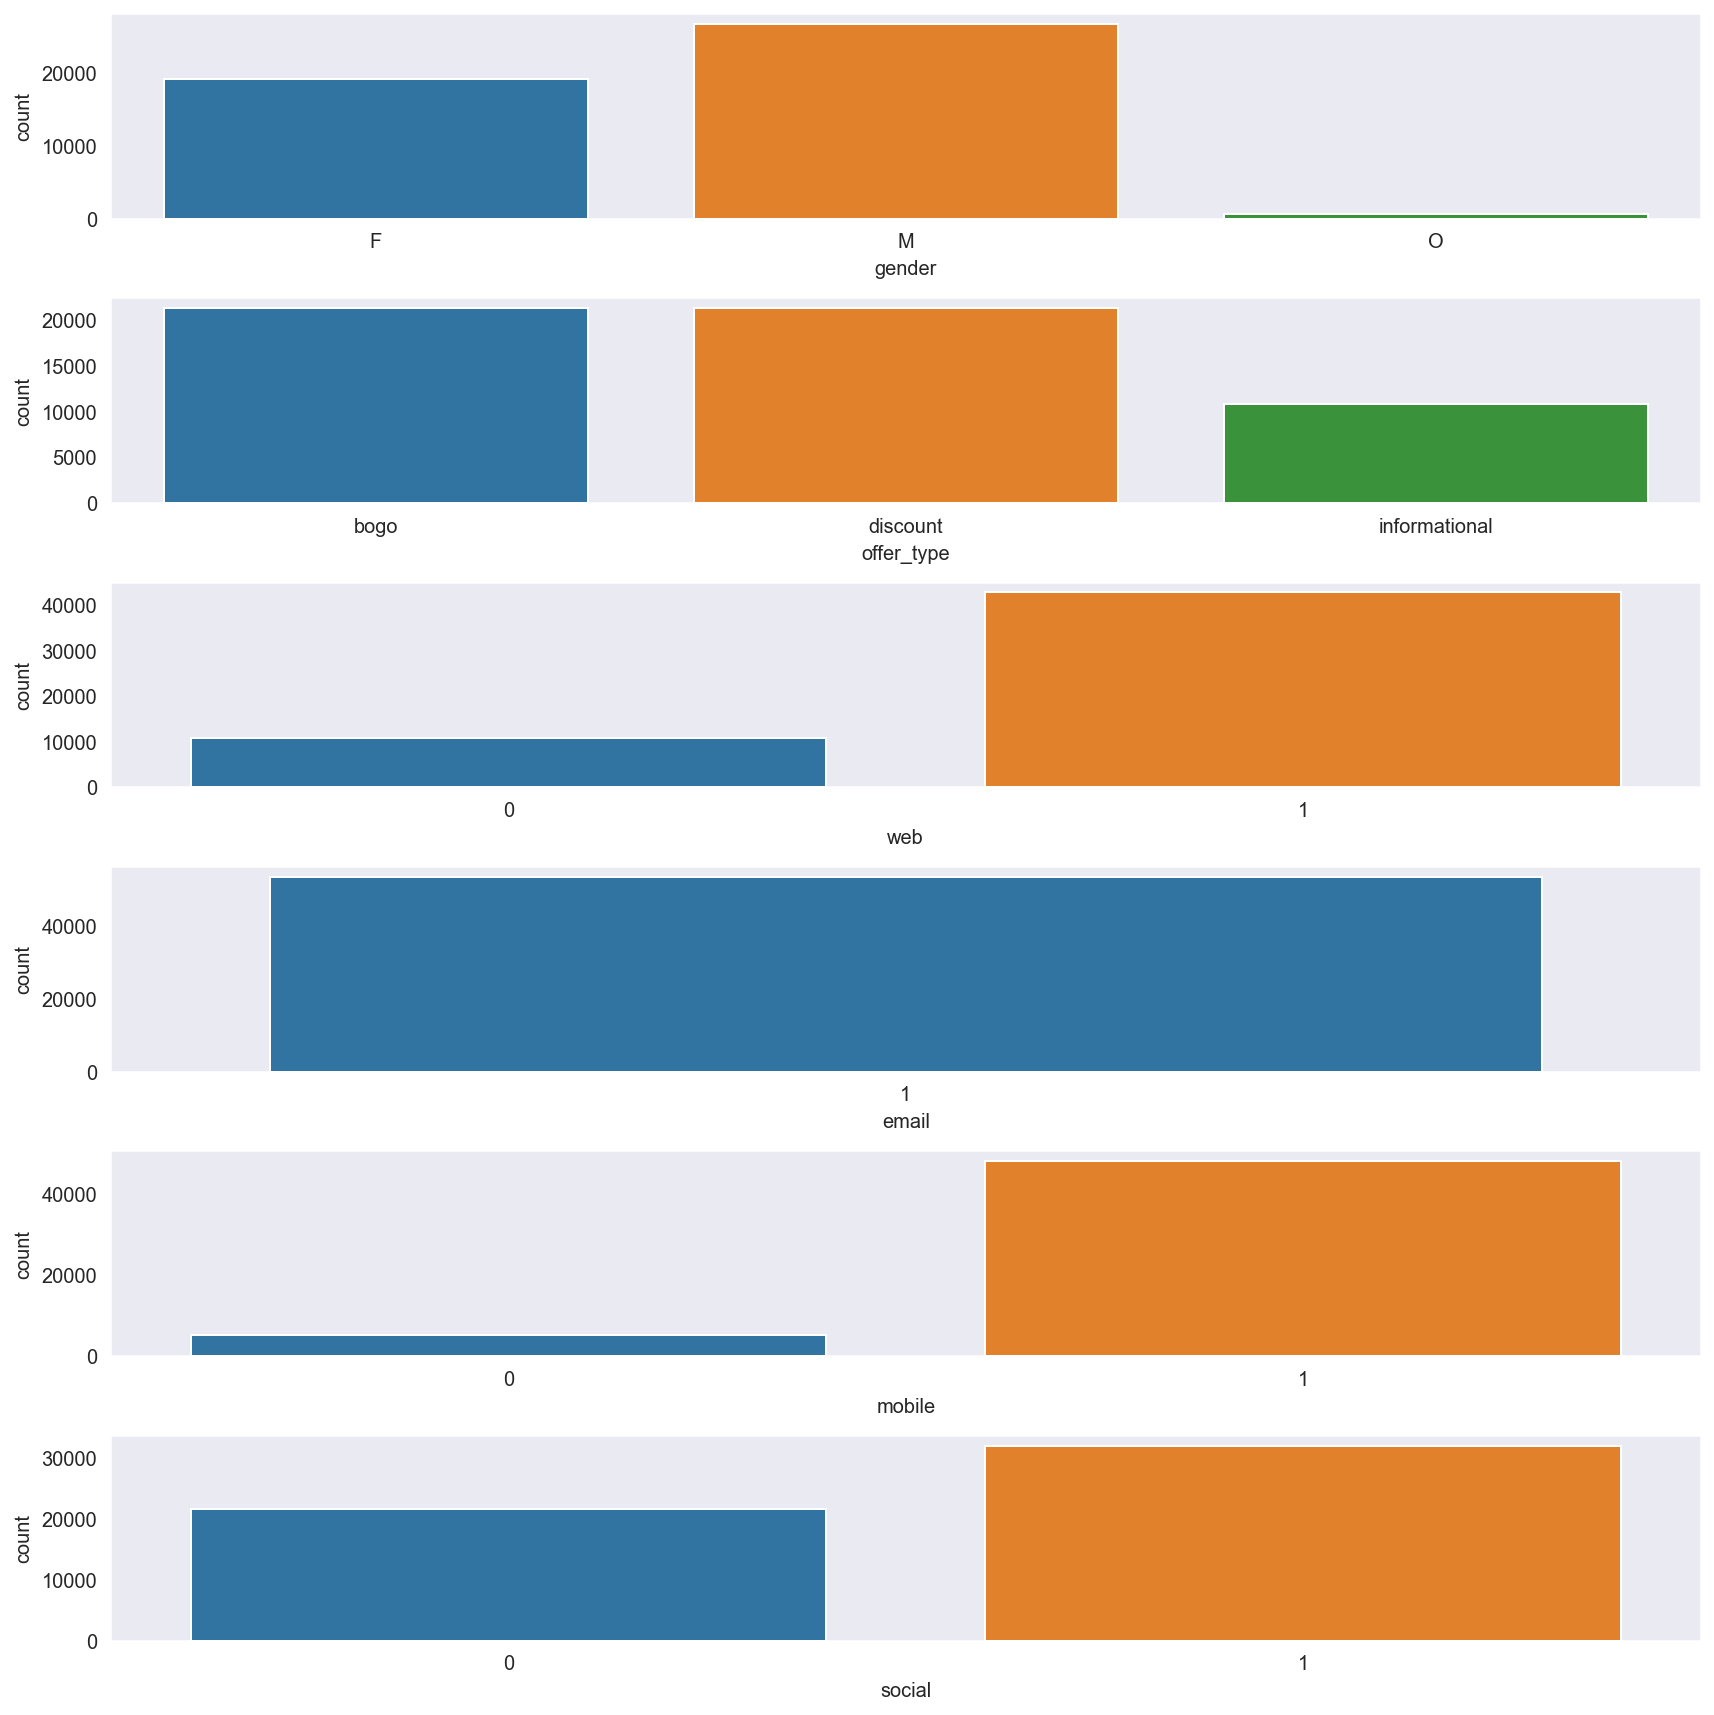

In [53]:
countplot(df_train, CAT_FEATURES)

##### Bivariate Analysis

Surprisingly, there is a greater share of respondents in `offer_type` informational in comparison to other types. Regarding `gender`, there are fewer examples of oblivious to conclude anything at all with statistical confidence, so we could infer that females are more prone to responding to a promotional offer than males. 

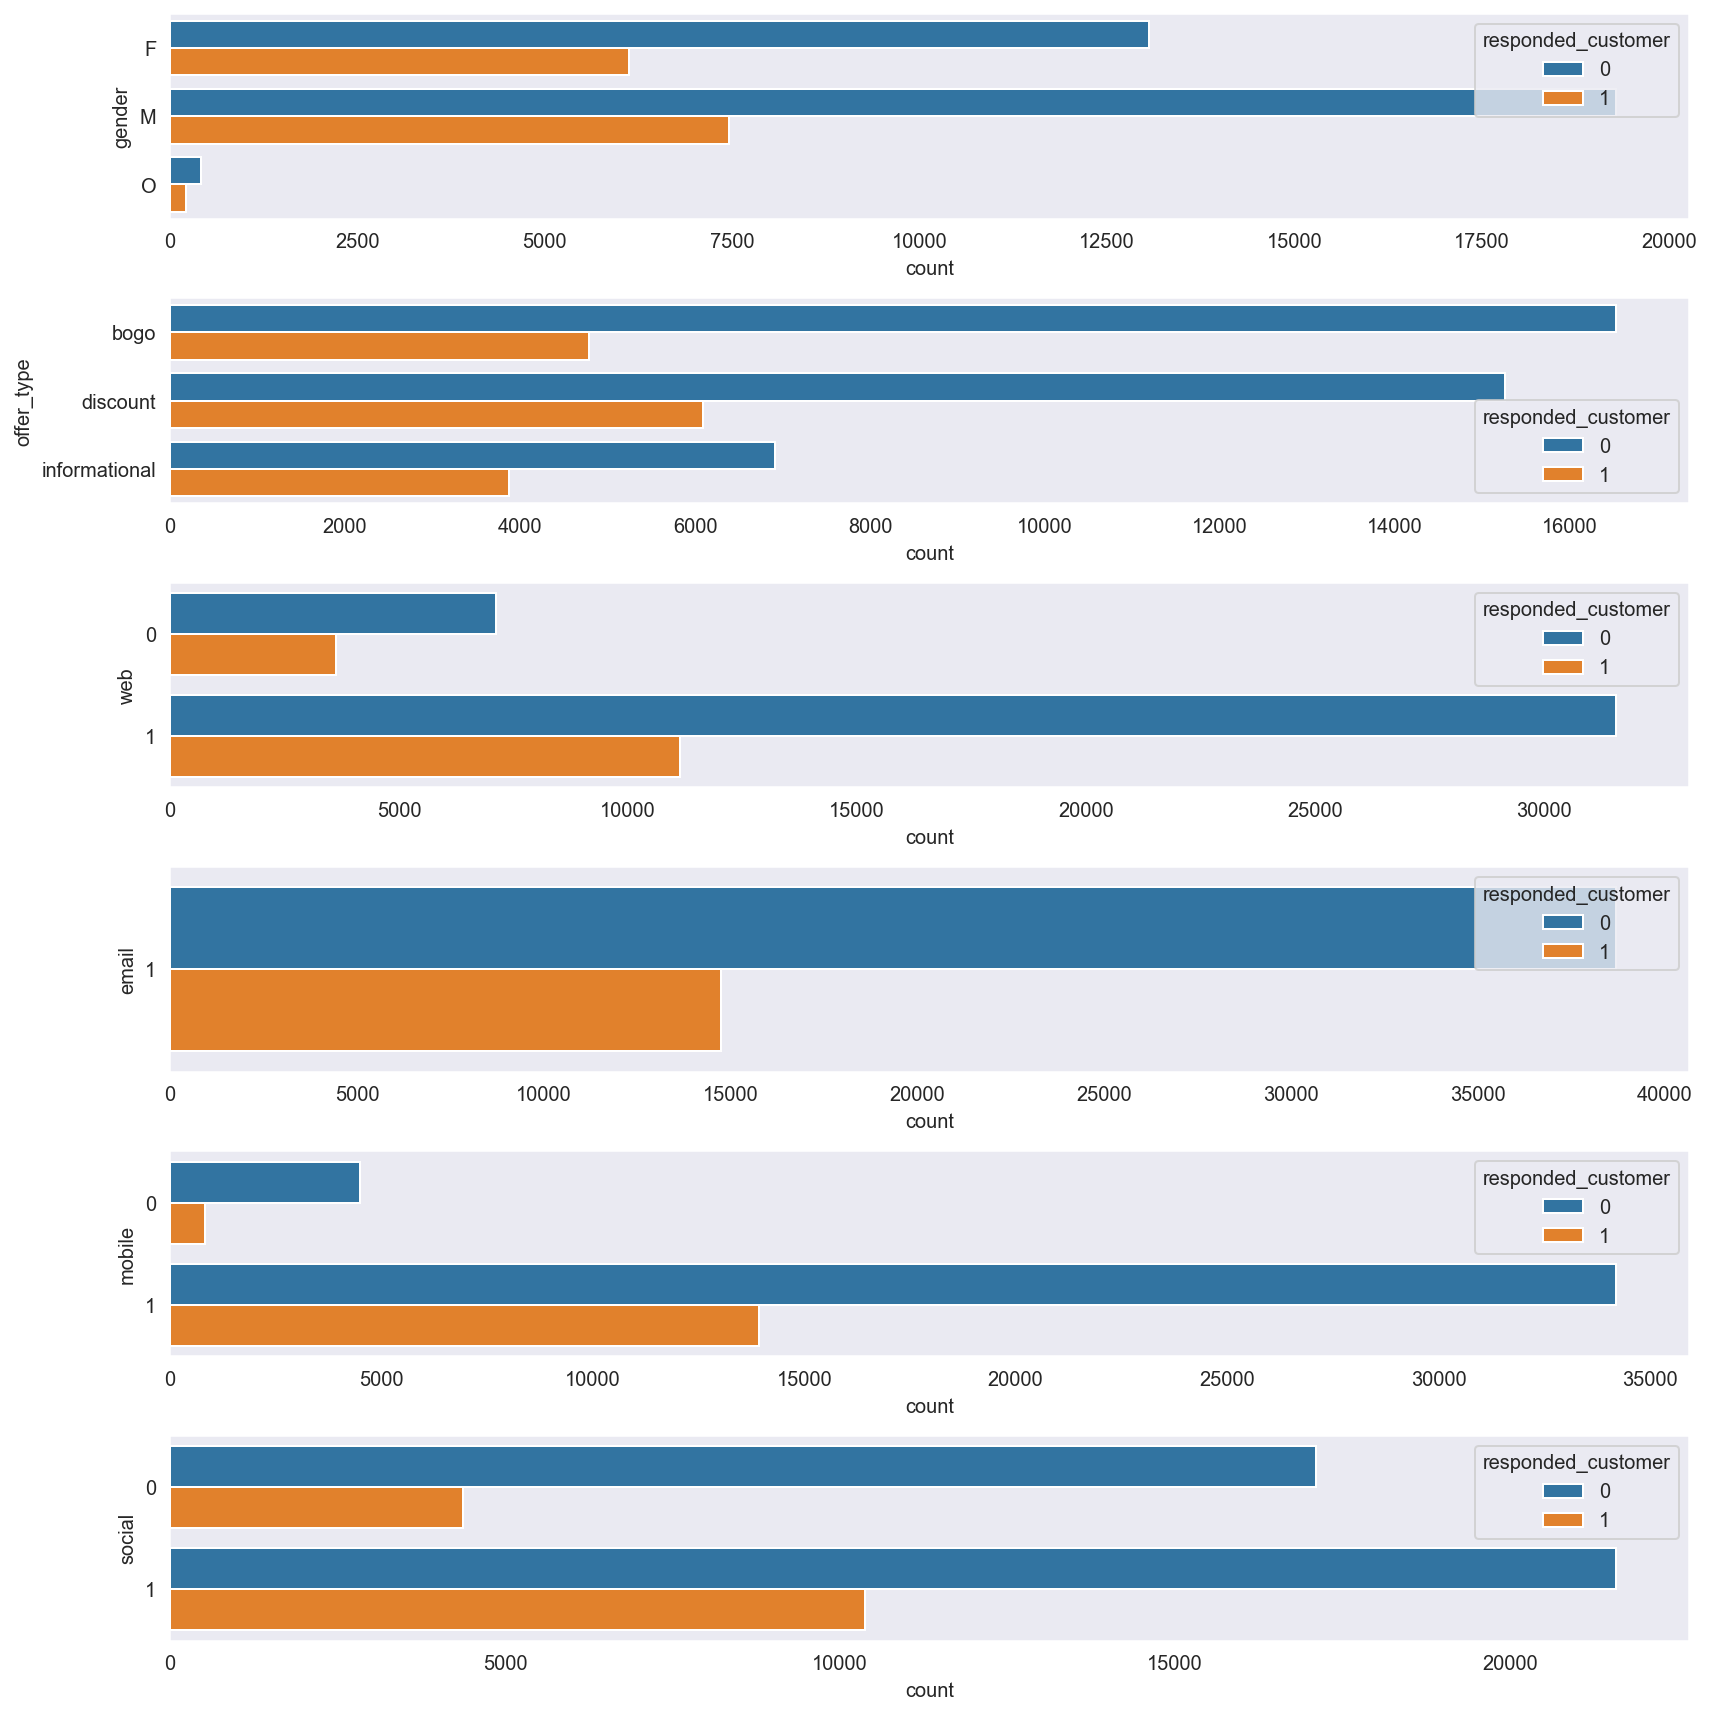

In [54]:
countplot(df_train, CAT_FEATURES, hue=TARGET)

### 5. Preprocessing and XGBoost with Default Parameters

In order to allow further model training and hyperparameter tuning in SageMaker, here we will only build the pipeline and fit it in order to assess feasibility.

Further development will take place in the scripts uploaded to SageMaker.

Let's select then the features we are going to use in our final model. Notice that we removed `duration`, since `difficulty` has a better relationship to the target variable.

In [55]:
NUM_FEATURES = [
    "age", "membership_duration", "reward", "difficulty",
    "duration", "average_purchase", "frequency"
]

CAT_FEATURES = [
    "gender", "offer_type"
]

CAT_FEATURES_ENCODED = [
    "web", "email", "mobile", "social"
]

TARGET = "responded_customer"

In [56]:
X_train, y_train = df_train.loc[:, NUM_FEATURES+CAT_FEATURES+CAT_FEATURES_ENCODED], \
                   df_train.loc[:, TARGET].values

X_test, y_test = df_test.loc[:, NUM_FEATURES+CAT_FEATURES+CAT_FEATURES_ENCODED], \
                 df_test.loc[:, TARGET].values

#### 5.1. Preprocessing Pipeline

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from imblearn.over_sampling import SMOTE

In [58]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols: list):
        """ Custom sklearn transformer to select a set of columns.

        Attributes:
            cols (list of str) representing the columns to be selected 
            in a pandas DataFrame.
                
        """
        self.__cols = cols
        self.__pd_df = pd.DataFrame
        
    @property
    def cols(self):
        return self.__cols
    
    def get_feature_names(self):
        return self.__cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, self.__pd_df), "`X` should be a pandas dataframe"
        return X.loc[:, self.__cols]
    
class NumericImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, method: str = "mean", fill_value=None):
        """ Custom sklearn transformer to impute numeric data when it is missing.

        Attributes:
            method (str) representing the method (mean/median/constant)
            fill_value (int/float) representing the constant value to be imputed 
                
        """
        assert method in ["mean", "median", "constant"], \
               "Allowed methods are `mean`, `median`, `constant`"
        if method == "constant":
            assert fill_value is not None, "Fill value must be provided for `constant`"
        self.__method = method
        self.__fill_value = fill_value
        self.__learned_values = {}
        self.__cols = []
        self.__pd_df = pd.DataFrame
        self.__np_mean = np.mean
        self.__np_median = np.median
        
    @property
    def method(self):
        return self.__method
    
    @property
    def fill_value(self):
        return self.__fill_value
    
    @property
    def learned_values(self):
        return self.__learned_values
    
    def __define_func(self):
        if self.__method == "mean":
            return self.__np_mean
        elif self.__method == "median":
            return self.__np_median
        
    def get_feature_names(self):
        return self.__cols
    
    def fit(self, X, y=None):
        assert isinstance(X, self.__pd_df), "`X` should be a pandas dataframe"
        X_ = X.copy()
        self.__cols = X_.columns
        if self.__method in ["mean", "median"]:
            func = self.__define_func()
            for column in X_.columns:
                self.__learned_values[column] = func(X_.loc[~X_[column].isnull(), column])
        elif self.__method == "constant":
            for column in X_.columns:
                self.__learned_values[column] = self.__fill_value
        return self
    
    def transform(self, X):
        assert isinstance(X, self.__pd_df), "`X` should be a pandas dataframe"
        X_ = X.copy()
        for column in X_.columns:
            X_.loc[X_[column].isnull(), column] = self.__learned_values[column]
        return X_
    

class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, method: str = "most_frequent", fill_value=None):
        """ Custom sklearn transformer to impute categorical data when it is missing.

        Attributes:
            method (str) representing the method (most_frequent/constant)
            fill_value (int/str) representing the constant value to be imputed 
                
        """
        assert method in ["most_frequent", "constant"], \
               "Allowed methods are `most_frequent`, `constant`"
        if method == "constant":
            assert fill_value is not None, "Fill value must be provided for `constant`"
        self.__method = method
        self.__fill_value = fill_value
        self.__learned_values = {}
        self.__cols = []
        self.__pd_df = pd.DataFrame
        
    @property
    def method(self):
        return self.__method
    
    @property
    def fill_value(self):
        return self.__fill_value
    
    @property
    def learned_values(self):
        return self.__learned_values
    
    def get_feature_names(self):
        return self.__cols
    
    def fit(self, X: pd.DataFrame, y=None):
        assert isinstance(X, self.__pd_df), "`X` should be a pandas dataframe"
        X_ = X.copy()
        self.__cols = X_.columns
        if self.__method == "most_frequent":
            for column in X_.columns:
                self.__learned_values[column] = X_.loc[:, column].value_counts(ascending=False).index[0]
        elif self.__method == "constant":
            for column in X_.columns:
                self.__learned_values[column] = self.__fill_value
        return self
    
    def transform(self, X):
        assert isinstance(X, self.__pd_df), "`X` should be a pandas dataframe"
        X_ = X.copy()
        for column in X_.columns:
            X_.loc[X_[column].isnull(), column] = self.__learned_values[column]
        return X_

In [59]:
num_preprocessing = Pipeline(steps=[
    ("num_cols", ColumnSelector(cols=NUM_FEATURES)),
    ("num_imputer", NumericImputer(method="median")),
    ("std_scaler", StandardScaler())
])

cat_preprocessing = Pipeline(steps=[
    ("cat_cols", ColumnSelector(cols=CAT_FEATURES)),
    ("cat_imputer", CategoricalImputer(method="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

cat_encoded_preprocessing = Pipeline(steps=[
    ("cat_encoded_cols", ColumnSelector(cols=CAT_FEATURES_ENCODED)),
    ("cat_encoded_imputer", CategoricalImputer(method="most_frequent")),
])

preprocessor = FeatureUnion(transformer_list=[
    ("num_preprocessing", num_preprocessing),
    ("cat_preprocessing", cat_preprocessing),
    ("cat_encoded_preprocessing", cat_encoded_preprocessing),
])

In [60]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [61]:
RESAMPLING_RATE = 0.7

smote = SMOTE(sampling_strategy=RESAMPLING_RATE)
X_train_rebalanced, y_train_rebalanced = smote.fit_resample(X_train_preprocessed, y_train)

#### 5.2. Model Development

In [62]:
from xgboost import XGBClassifier

In [63]:
xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='error',
        n_estimators=100,
        max_depth=3,
        gamma=0,
        learning_rate=0.1,
        scale_pos_weight=1/RESAMPLING_RATE,
        random_state=99
)

In [64]:
xgb.fit(X_train_rebalanced, y_train_rebalanced)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=99,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.4285714285714286,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

#### 5.3. Model Inference

In [65]:
inference_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("xgboost", xgb)
])

In [66]:
inference_pipeline.predict(X_test)

array([0, 0, 0, ..., 0, 1, 0])

In [67]:
inference_pipeline.predict_proba(X_test)

array([[0.5246988 , 0.4753012 ],
       [0.5416169 , 0.45838305],
       [0.5416169 , 0.45838305],
       ...,
       [0.69671553, 0.30328447],
       [0.4859926 , 0.5140074 ],
       [0.5131584 , 0.48684162]], dtype=float32)

____

In [68]:
import dill

with open("model.pkl", "wb") as file:
    dill.dump(inference_pipeline, file)